In [614]:
import numpy as np
import pandas as pd
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sea

from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_exam import Gen_spec

import fsps
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate


import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [615]:
args = np.load('../data/multifit_data/fit_args.npy')[0]

def Gen_multibeams(beams, args = args):
    mb = multifit.MultiBeam(beams,**args)

    grism_beams = {}
    for g in mb.PA:
        grism_beams[g.lower()] = []
        for pa in mb.PA[g]:
            for i in mb.PA[g][pa]:
                grism_beams[g.lower()].append(mb.beams[i])

    mb_g102 = multifit.MultiBeam(grism_beams['g102'], fcontam=mb.fcontam, 
                                 min_sens=mb.min_sens, min_mask=mb.min_mask, 
                                 group_name=mb.group_name+'-g102')
    # bug, will be fixed ~today to not have to do this in the future
    for b in mb_g102.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb_g102.initialize_masked_arrays()

    mb_g141 = multifit.MultiBeam(grism_beams['g141'], fcontam=mb.fcontam, 
                                 min_sens=mb.min_sens, min_mask=mb.min_mask, 
                                 group_name=mb.group_name+'-g141')
    # bug, will be fixed ~today to not have to do this in the future
    for b in mb_g141.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb_g141.initialize_masked_arrays()
    
    return mb_g102, mb_g141

def Gen_model(sp, params, masses, agebins = 10, SF = False, SFH = False):
    #### make sure fsps is initialized correctly####
    """
    return a spectrum
    
    sp : fsps object
    params : should be ordered as metallicity (Z), age (a), Av (d)
    masses : masses used to create SFH
    agebins : how many bins used for SFH
    SF : boolean, if SF then dust1 = 0
    SFH : boolean, whether or not to return SFH
    """
    Z, a, d = params

    if SF:
        sp.params['dust1'] = 0 
    else:
        sp.params['dust1'] = d
        
    sp.params['dust2'] = d
    sp.params['logzsol'] = np.log10(Z)

    time, sfr, tmax = convert_sfh(get_agebins(a, binnum = agebins), masses , maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 

    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    if SFH:  
        return wave, flux, time, sfr
    else:
        return wave, flux
     
def Gen_temp_dict(redshift, lowlim, hilim, args = args):
    temps = {}
    
    for k in args['t1']:
        if k[0] == 'l' and lowlim < args['t1'][k].wave[args['t1'][k].flux == args['t1'][k].flux.max()][0] * (1+redshift) < hilim:
            temps[k] = args['t1'][k]
                
    return temps

def Gen_temp_dict_balm(redshift, lowlim, hilim, lines, args = args):
    temps = {}
    
    balmer = []
    
    for ln in lines:
        balmer.append('line ' + ln)
        
    for k in args['t1']:
        if k in balmer and lowlim < args['t1'][k].wave[args['t1'][k].flux == args['t1'][k].flux.max()][0] * (1+redshift) < hilim:
            temps[k] = args['t1'][k]
                
    return temps

def spec_construct(g102_fit,g141_fit, z, wave0 = 4000, usetilt = True):
    flat = np.ones_like(g141_fit['cont1d'].wave)
    slope = flat*(g141_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g141_fit['cfit']['fsps_model'][0]+slope * g141_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g141_fit['cont1d'].flux / tilt

    line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
    untilted_line_g141 = untilted_continuum*(1+line_g141)


    flat = np.ones_like(g102_fit['cont1d'].wave)
    slope = flat*(g102_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g102_fit['cfit']['fsps_model'][0]+slope * g102_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g102_fit['cont1d'].flux / tilt

    line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
    untilted_line_g102 = untilted_continuum*(1+line_g102)

    FL = np.append(untilted_line_g102[g102_fit['cont1d'].wave <= 12000],untilted_line_g141[g102_fit['cont1d'].wave > 12000])
    return g102_fit['cont1d'].wave, FL

def Plot_grism_fit(MB, fit, instr, ax, color, lims):
    spec = fit['line1d'].wave, fit['line1d'].flux
    spf = fit['line1d'].wave, fit['line1d'].wave*0+1


    for i in range(MB.N):
        beam = MB.beams[i]
        b_mask = beam.fit_mask.reshape(beam.sh)

        m_i = beam.compute_model(spectrum_1d=spec, is_cgs=True, in_place=False).reshape(beam.sh)
        f_i = beam.compute_model(spectrum_1d=spf, is_cgs=True, in_place=False).reshape(beam.sh)

        grism = beam.grism.filter

        w, flm, erm = beam.beam.optimal_extract(m_i, bin=1, ivar=beam.ivar*b_mask)
        w, sens, ers = beam.beam.optimal_extract(f_i, bin=1, ivar=beam.ivar*b_mask)

        sens[~np.isfinite(sens)] = 1

        unit_corr = 1./sens

        clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

        flm *= unit_corr

        ax.plot(w[clip], flm[clip], color='k', alpha=0.2, linewidth=1, zorder=2) 

    sptbl = MB.oned_spectrum(tfit = fit)

    w = sptbl[instr]['wave']
    f = sptbl[instr]['flux']
    e = sptbl[instr]['err']
    fl = sptbl[instr]['flat']
        
    clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

    ax.errorbar(w[clip],f[clip]/fl[clip],e[clip]/fl[clip], color = color,
                linestyle='None', marker='o', markersize=0.25, zorder = 1, elinewidth = 1)

In [616]:
from spec_tools import Derive_SFH_weights, z_at_value, boot_to_posterior, Rescale_sfh, Gen_PPF

class Rescale_sfh_m(object):
    def __init__(self, field, galaxy, fn, trials = 1000):

        ppf_dict = {}
        params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabMfit{2}_P{3}.npy'.format(field, galaxy, fn, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabMfit{2}_Pz.npy'.format(field, galaxy, fn))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []
        t_80_grid = []
        t_90_grid = []
        t_q_grid = []

        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0]), draw[1:11], maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**draw[11] / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))
                t_80_grid.append(interp1d(M/ M[-1], T)(0.2))
                t_90_grid.append(interp1d(M/ M[-1], T)(0.1))

                sfrmax = np.argmax(lbsfr) 

                check = False
                for i in range(len(lbsfr[0:sfrmax+1])):
                    if int(lbsfr[0:sfrmax+1][-(i+1)]) <= int(max(lbsfr[0:sfrmax+1]) * 0.1):
                        t_q_grid.append(lbt[0:sfrmax+1][-(i+1)])
                        break
                if not check:
                    t_q_grid.append(lbt[0:sfrmax+1][-(i+1)])

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**draw[11])
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_80_grid[0:trials], weights)
        self.t_80, self.t_80_hci, self.t_80_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_90_grid[0:trials], weights)
        self.t_90, self.t_90_hci, self.t_90_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)
        self.t_80 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.8)
        self.t_90 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.9)
        
        x,y = boot_to_posterior(t_q_grid[0:trials], weights)
        self.t_q, self.t_q_hci, self.t_q_offreg = Highest_density_region(y,x) 

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

        self.z_80 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_80)*u.Gyr)
        hci=[]
        for lims in self.t_80_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_80_hci = np.array(hci)
        self.z_80_offreg = np.array(self.t_80_offreg)
                       
        self.z_90 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_90)*u.Gyr)
        hci=[]
        for lims in self.t_90_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_90_hci = np.array(hci)
        self.z_90_offreg = np.array(self.t_90_offreg)
                       
        self.z_q = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_q)*u.Gyr)
        hci=[]
        for lims in self.t_q_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_q_hci = np.array(hci)
        self.z_q_offreg = np.array(self.t_q_offreg)
        
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)
            
        self.weights = weights
        self.t_50_grid = t_50_grid
        self.t_80_grid = t_80_grid
        self.t_90_grid = t_90_grid

# Q galaxy

In [67]:
Gs = Gen_spec('GND', 21156, 1.25, phot_errterm = 0.04, irac_err = 0.08) 
mb_g102_q, mb_g141_q = Gen_multibeams('../data/multifit_data/gdn-grism-j123656p6215_25319.beams.fits')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.iv

1 ib3721xiq_flt.fits G141
2 ib3721xmq_flt.fits G141
3 ib3721xyq_flt.fits G141
4 ib3721y2q_flt.fits G141
5 ib3725dyq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141
9 icat21cfq_flt.fits G102
10 icat21coq_flt.fits G102
11 icat21dgq_flt.fits G102
12 icat21dlq_flt.fits G102
13 icat25hcq_flt.fits G102
14 icat25hiq_flt.fits G102
15 icat25icq_flt.fits G102
16 icat25iiq_flt.fits G102
17 icxt51jvq_flt.fits G102
18 icxt51jwq_flt.fits G102
19 icxt51jzq_flt.fits G102
20 icxt51k1q_flt.fits G102
21 icxt52i0q_flt.fits G102
22 icxt52i1q_flt.fits G102
23 icxt52i4q_flt.fits G102
24 icxt52i6q_flt.fits G102
25 icxt53i9q_flt.fits G102
26 icxt53iaq_flt.fits G102
27 icxt53idq_flt.fits G102
28 icxt53ifq_flt.fits G102
29 icxt55krq_flt.fits G102
30 icxt55ksq_flt.fits G102
31 icxt55kvq_flt.fits G102
32 icxt55kxq_flt.fits G102
33 icxta4mdq_flt.fits G102
34 icxta4meq_flt.fits G102
35 icxta4mhq_flt.fits G102
36 icxta4mjq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2922: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((fl-er*0.)[clip], 5))
/Users/vestrada/minicon

[Text(0,0,'0.8'),
 Text(0,0,'1'),
 Text(0,0,'1.2'),
 Text(0,0,'1.4'),
 Text(0,0,'1.6')]

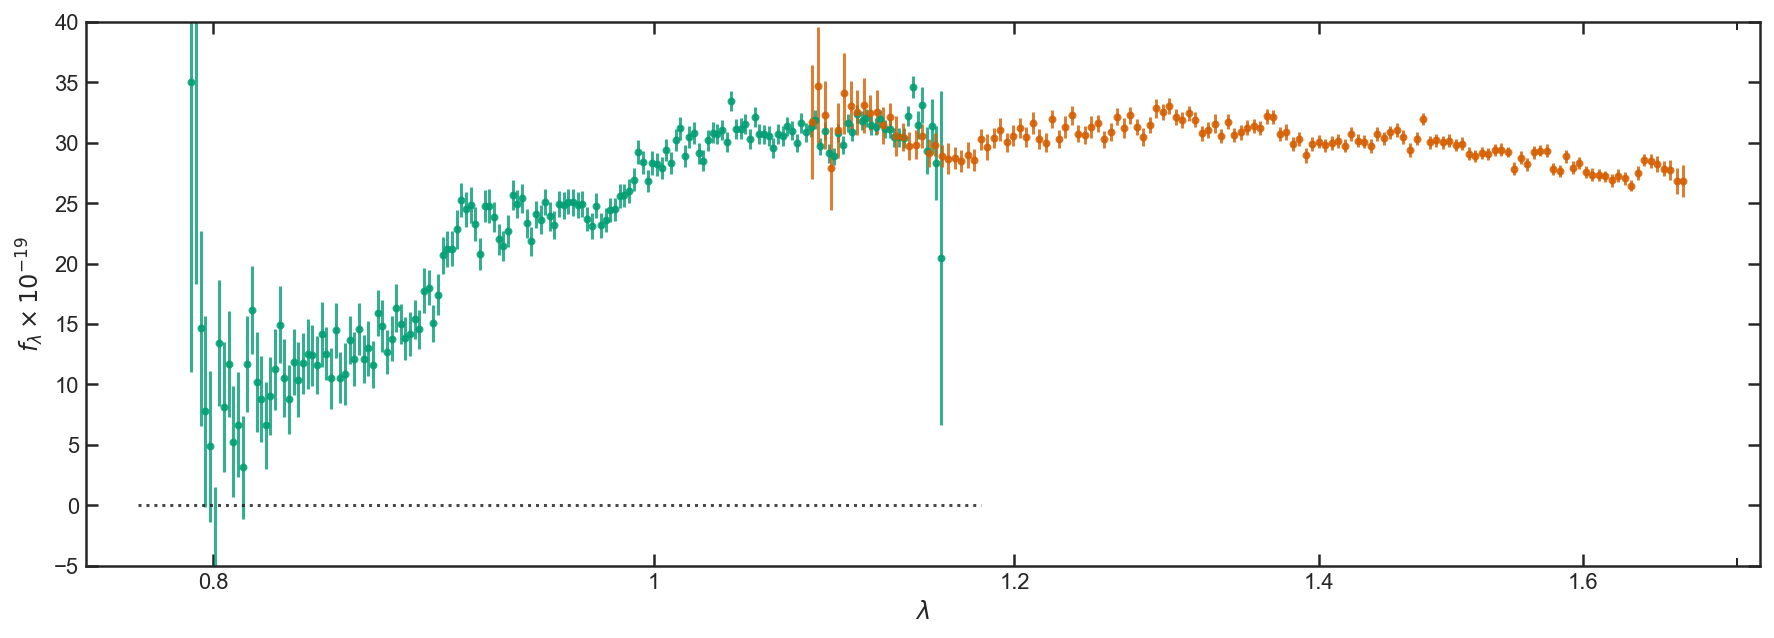

In [68]:
fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(111)

mb_g102_q.oned_figure(show_beams=False, axc=ax1)
mb_g141_q.oned_figure(show_beams=False, axc=ax1)

ax1.set_xlim(.75,1.75)
ax1.set_ylim(-5,40)
ax1.set_xticks([0.8,1,1.2,1.4,1.6])
ax1.set_xticklabels([0.8,1,1.2,1.4,1.6])

In [69]:
Q_temps = Gen_temp_dict_balm(1.25, lowlim = 8000, hilim = 16000,lines=['Ha'])

In [70]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

bfm, bfa, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfm7, bfm8, bfm9, bfm10, bfz, bfd, bfsb, bfsr, bflogz = np.load(
    '../data/posteriors/GND_21156_tabMfit7_bfit.npy')

wave, flux = Gen_model(sp, [bfm, bfa, bfd], [bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfm7, bfm8, bfm9, bfm10])

In [31]:
wave0 = 4000
# Q_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)

In [71]:
Q_temps['fsps_model'] = SpectrumTemplate(wave, flux+ sb*flux*(wave-wave0)/wave0)

g102_fit = mb_g102_q.template_at_z(bfz, templates =Q_temps, fitter = 'lstsq')
Q_temps['fsps_model'] = SpectrumTemplate(wave, flux+ sr*flux*(wave-wave0)/wave0)

g141_fit = mb_g141_q.template_at_z(bfz, templates =Q_temps, fitter = 'lstsq')

wv_obs = wave * (1+bfz)
flam = F_lam_per_M(flux, wv_obs, bfz, 0, sp.stellar_mass)
Pmfl = Gs.Sim_phot_mult(wv_obs,flam)
scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

In [72]:
g102_fit['cfit'],g102_fit['chi2'], mb_g102_q.DoF

(OrderedDict([('bg 000', (-0.0014666746946343165, 0.0005667679850154515)),
              ('bg 001', (-0.002499211775138975, 0.0006211364976128547)),
              ('bg 002', (-0.001353028917727754, 0.0005733193584371041)),
              ('bg 003', (-0.0011672545294154207, 0.000580714755393034)),
              ('bg 004', (-0.0017772340288505356, 0.0005659919525324567)),
              ('bg 005', (-0.002290564849828959, 0.0006361751803168138)),
              ('bg 006', (-0.0018060821295962856, 0.0005719602058719046)),
              ('bg 007', (-0.002081257071308039, 0.0005841158280151015)),
              ('bg 008', (-0.011250202755563793, 0.0006456756753360233)),
              ('bg 009', (-0.009706864717781115, 0.0010055822543258855)),
              ('bg 010', (-0.009016659298525007, 0.0006307507003721028)),
              ('bg 011', (-0.00969104029808368, 0.000867794532609041)),
              ('bg 012', (-0.0029482566392949744, 0.0006078344126558474)),
              ('bg 013', (-0.0036754

In [73]:
g141_fit['cfit'],g141_fit['chi2'], mb_g141_q.DoF

(OrderedDict([('bg 000', (-0.0018723824603497363, 0.000831433898979729)),
              ('bg 001', (0.00015338217141106641, 0.0008794642247691493)),
              ('bg 002', (-0.0012365876994708466, 0.0008394526663989145)),
              ('bg 003', (0.0006725734442687772, 0.0008367923897053436)),
              ('bg 004', (-0.001703802838803857, 0.00074208024508558)),
              ('bg 005', (-0.0026082460542833016, 0.0008060789502257874)),
              ('bg 006', (-0.0036075269571846577, 0.0007497787004922351)),
              ('bg 007', (-0.0010660194366427164, 0.0007481245696954076)),
              ('line Ha', (5.835965169151605e-17, 7.919207518086874e-18)),
              ('fsps_model',
               (1.3188953073283204e-13, 3.5950262925198493e-16))]),
 15654.666560051553,
 15147)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)


[Text(0,0,'5000'), Text(0,0,'10000'), Text(0,0,'50000')]

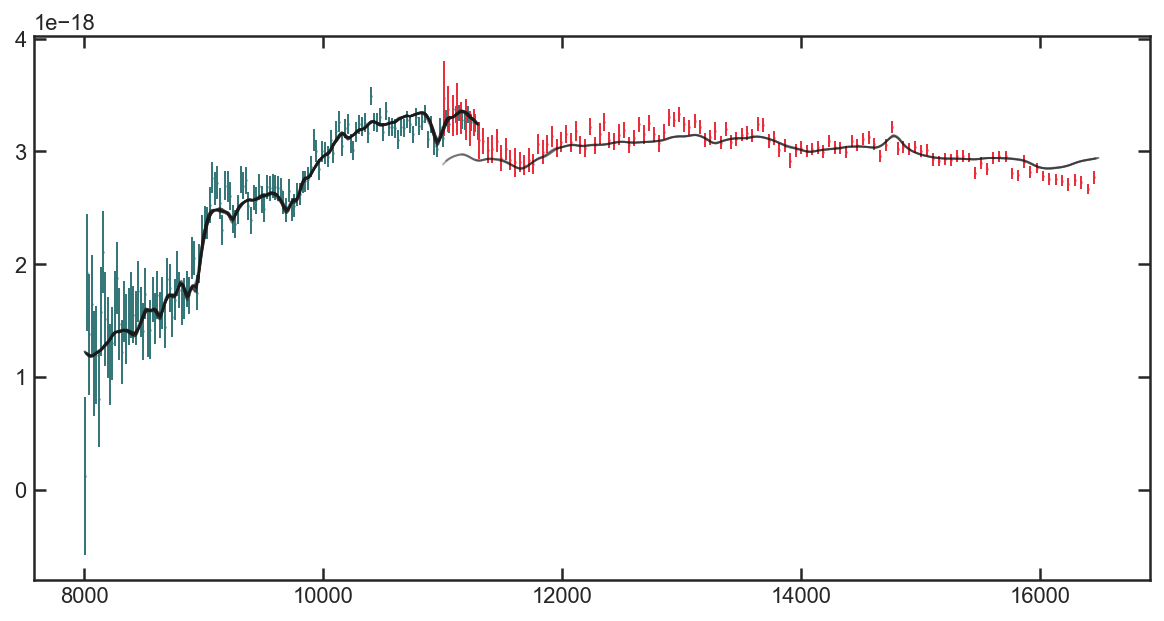

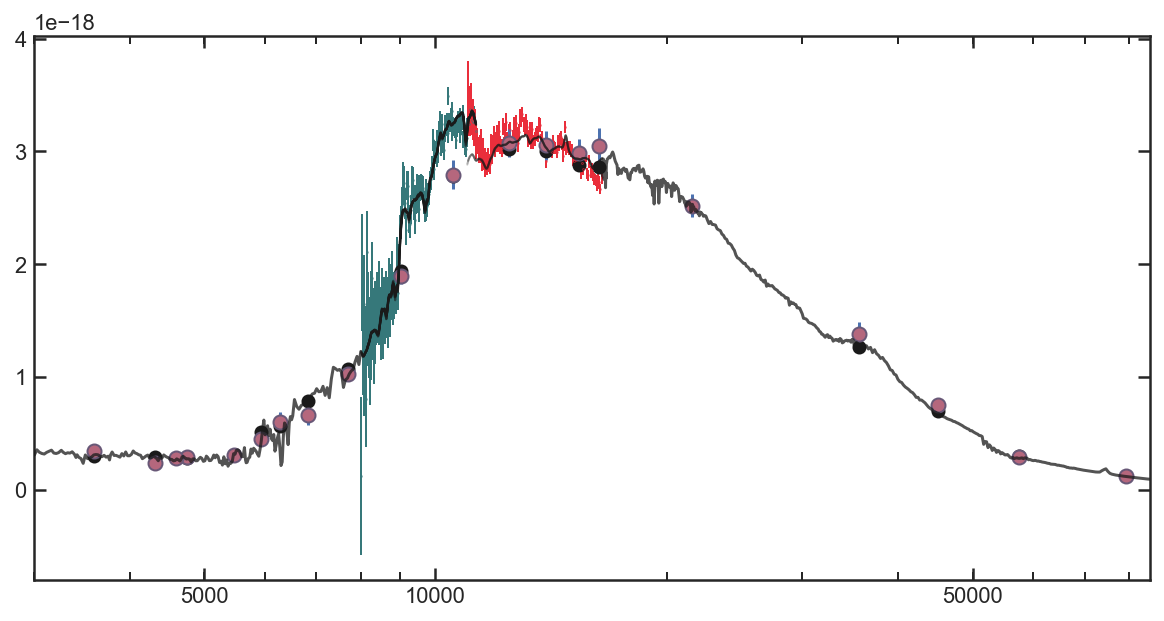

In [74]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot()
Plot_grism_fit(mb_g102_q, g102_fit, 'G102', ax, '#36787A', [8000,11300])
Plot_grism_fit(mb_g141_q, g141_fit, 'G141', ax, '#EA2E3B', [11000,16500])

fig = plt.figure(figsize=[10,5])
ax = plt.subplot()
Plot_grism_fit(mb_g102_q, g102_fit, 'G102', ax, '#36787A', [8000,11300])
Plot_grism_fit(mb_g141_q, g141_fit, 'G141', ax, '#EA2E3B', [11000,16500])

ax.errorbar(Gs.Pwv,Gs.Pflx,Gs.Perr,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
ax.scatter(Gs.Pwv, scl*Pmfl, color = 'k', marker='o')

IDB = [U for U in range(len(wv_obs)) if wv_obs[U] < 8000]
IDR = [U for U in range(len(wv_obs)) if wv_obs[U] > 16500]

ax.plot(wv_obs[IDB], flam[IDB]*scl,'k', alpha = 0.75, zorder=5)
ax.plot(wv_obs[IDR], flam[IDR]*scl,'k', alpha = 0.75)

ax.set_xscale('log')
ax.set_xlim(3000,85000)
ax.set_xticks([5000,10000,50000])
ax.set_xticklabels([5000,10000,50000])

In [75]:
Q_temps = Gen_temp_dict_balm(1.25, lowlim = 8000, hilim = 16000,lines=['Ha'])

Q_temps

{'line Ha': <grizli.utils.SpectrumTemplate at 0x1a758cc5f8>}

In [76]:
wave0 = 4000
Q_temps['fsps_model'] = SpectrumTemplate(wave, flux)
Q_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)

In [77]:
bfm, bfa, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfm7, bfm8, bfm9, bfm10, bfz, bfd, bflogz = np.load(
    '../data/posteriors/GND_21156_tabMfit5_bfit.npy')

wave, flux = Gen_model(sp, [bfm, bfa, bfd], [bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfm7, bfm8, bfm9, bfm10])

In [78]:
g102_fit = mb_g102_q.template_at_z(bfz, templates =Q_temps, fitter = 'lstsq')
g141_fit = mb_g141_q.template_at_z(bfz, templates =Q_temps, fitter = 'lstsq')

wv_obs = wave * (1+bfz)
flam = F_lam_per_M(flux, wv_obs, bfz, 0, sp.stellar_mass)
Pmfl = Gs.Sim_phot_mult(wv_obs,flam)
scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

In [79]:
g102_fit['cfit'],g102_fit['chi2'], mb_g102_q.DoF

(OrderedDict([('bg 000', (-0.001663202960652907, 0.0005689437475989517)),
              ('bg 001', (-0.00269650454632938, 0.0006231512316687254)),
              ('bg 002', (-0.0015486240582226127, 0.0005754527013173796)),
              ('bg 003', (-0.001362584631238832, 0.0005828220769700749)),
              ('bg 004', (-0.0019750756871217343, 0.000568200314412927)),
              ('bg 005', (-0.0024876299365201027, 0.0006381394983677744)),
              ('bg 006', (-0.0020012687463666842, 0.0005740907641283954)),
              ('bg 007', (-0.002277588957512351, 0.0005862309853058828)),
              ('bg 008', (-0.011481749676374858, 0.0006483709263498637)),
              ('bg 009', (-0.00993580311104559, 0.001007252410393689)),
              ('bg 010', (-0.009240567546489626, 0.0006333257369150489)),
              ('bg 011', (-0.009921300857882637, 0.0008697857545898381)),
              ('bg 012', (-0.003178649518606372, 0.0006106528109669528)),
              ('bg 013', (-0.003905826

In [80]:
g141_fit['cfit'],g141_fit['chi2'], mb_g141_q.DoF

(OrderedDict([('bg 000', (-0.0023027568918335267, 0.0008321570862490616)),
              ('bg 001', (-0.00046950895106420004, 0.0008808852744032573)),
              ('bg 002', (-0.0017248392606860827, 0.000840373794909623)),
              ('bg 003', (0.00024016906000538102, 0.0008375135296254047)),
              ('bg 004', (-0.0022398050952027945, 0.000743334192277402)),
              ('bg 005', (-0.0031256887761994187, 0.0008071550586953554)),
              ('bg 006', (-0.00415760123590788, 0.0007510855387094592)),
              ('bg 007', (-0.0015824132407220234, 0.0007492776818152937)),
              ('line Ha', (6.745783050623722e-17, 7.962449458498718e-18)),
              ('fsps_model', (1.440496370994753e-13, 1.0348722982755956e-15)),
              ('fsps_model_slope',
               (-1.3522997786846166e-14, 1.6140037737226416e-15))]),
 15498.03017854374,
 15147)

In [83]:
sb, -1.1097816120024852e-14/1.506590035344466e-13 , sr, -1.3522997786846166e-14/1.440496370994753e-13

(0.1, -0.07366181814343047, 0.05, -0.09387734713630476)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)


[Text(0,0,'5000'), Text(0,0,'10000'), Text(0,0,'50000')]

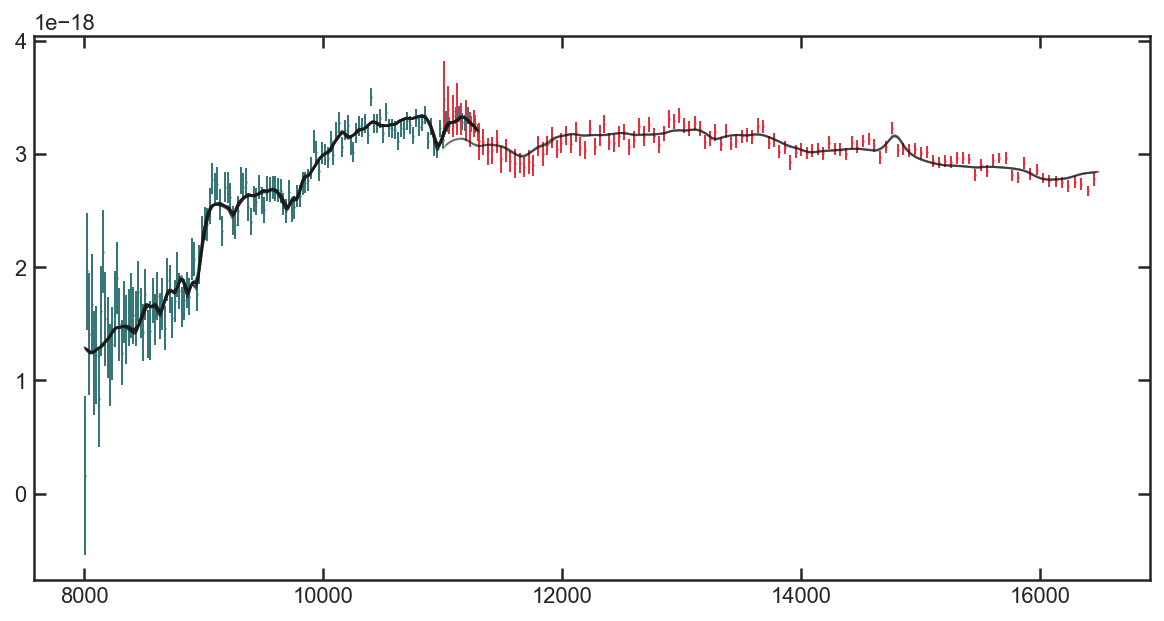

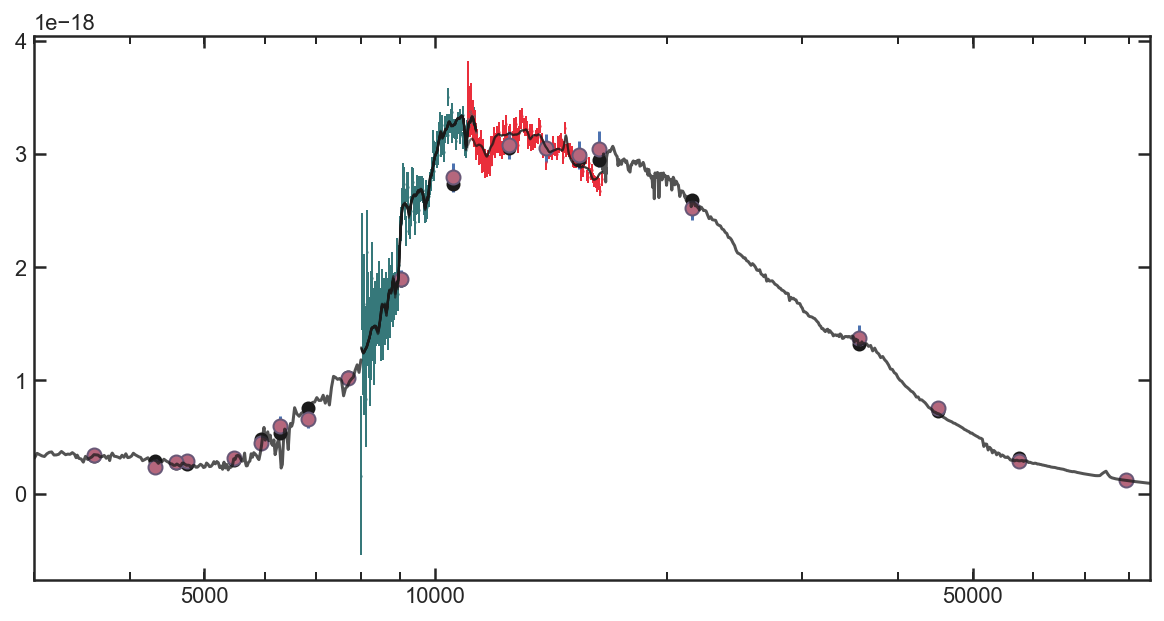

In [81]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot()
Plot_grism_fit(mb_g102_q, g102_fit, 'G102', ax, '#36787A', [8000,11300])
Plot_grism_fit(mb_g141_q, g141_fit, 'G141', ax, '#EA2E3B', [11000,16500])

fig = plt.figure(figsize=[10,5])
ax = plt.subplot()
Plot_grism_fit(mb_g102_q, g102_fit, 'G102', ax, '#36787A', [8000,11300])
Plot_grism_fit(mb_g141_q, g141_fit, 'G141', ax, '#EA2E3B', [11000,16500])

ax.errorbar(Gs.Pwv,Gs.Pflx,Gs.Perr,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
ax.scatter(Gs.Pwv, scl*Pmfl, color = 'k', marker='o')

IDB = [U for U in range(len(wv_obs)) if wv_obs[U] < 8000]
IDR = [U for U in range(len(wv_obs)) if wv_obs[U] > 16500]

ax.plot(wv_obs[IDB], flam[IDB]*scl,'k', alpha = 0.75, zorder=5)
ax.plot(wv_obs[IDR], flam[IDR]*scl,'k', alpha = 0.75)

ax.set_xscale('log')
ax.set_xlim(3000,85000)
ax.set_xticks([5000,10000,50000])
ax.set_xticklabels([5000,10000,50000])

In [4]:
sfh1 = Rescale_sfh('GND', 21156, trials = 5000)
sfh2 = Rescale_sfh_m('GND', 21156, 5, trials = 5000)
sfh3 = Rescale_sfh_m('GND', 21156, 6, trials = 5000)
sfh4 = Rescale_sfh_m('GND', 21156, 7, trials = 5000)

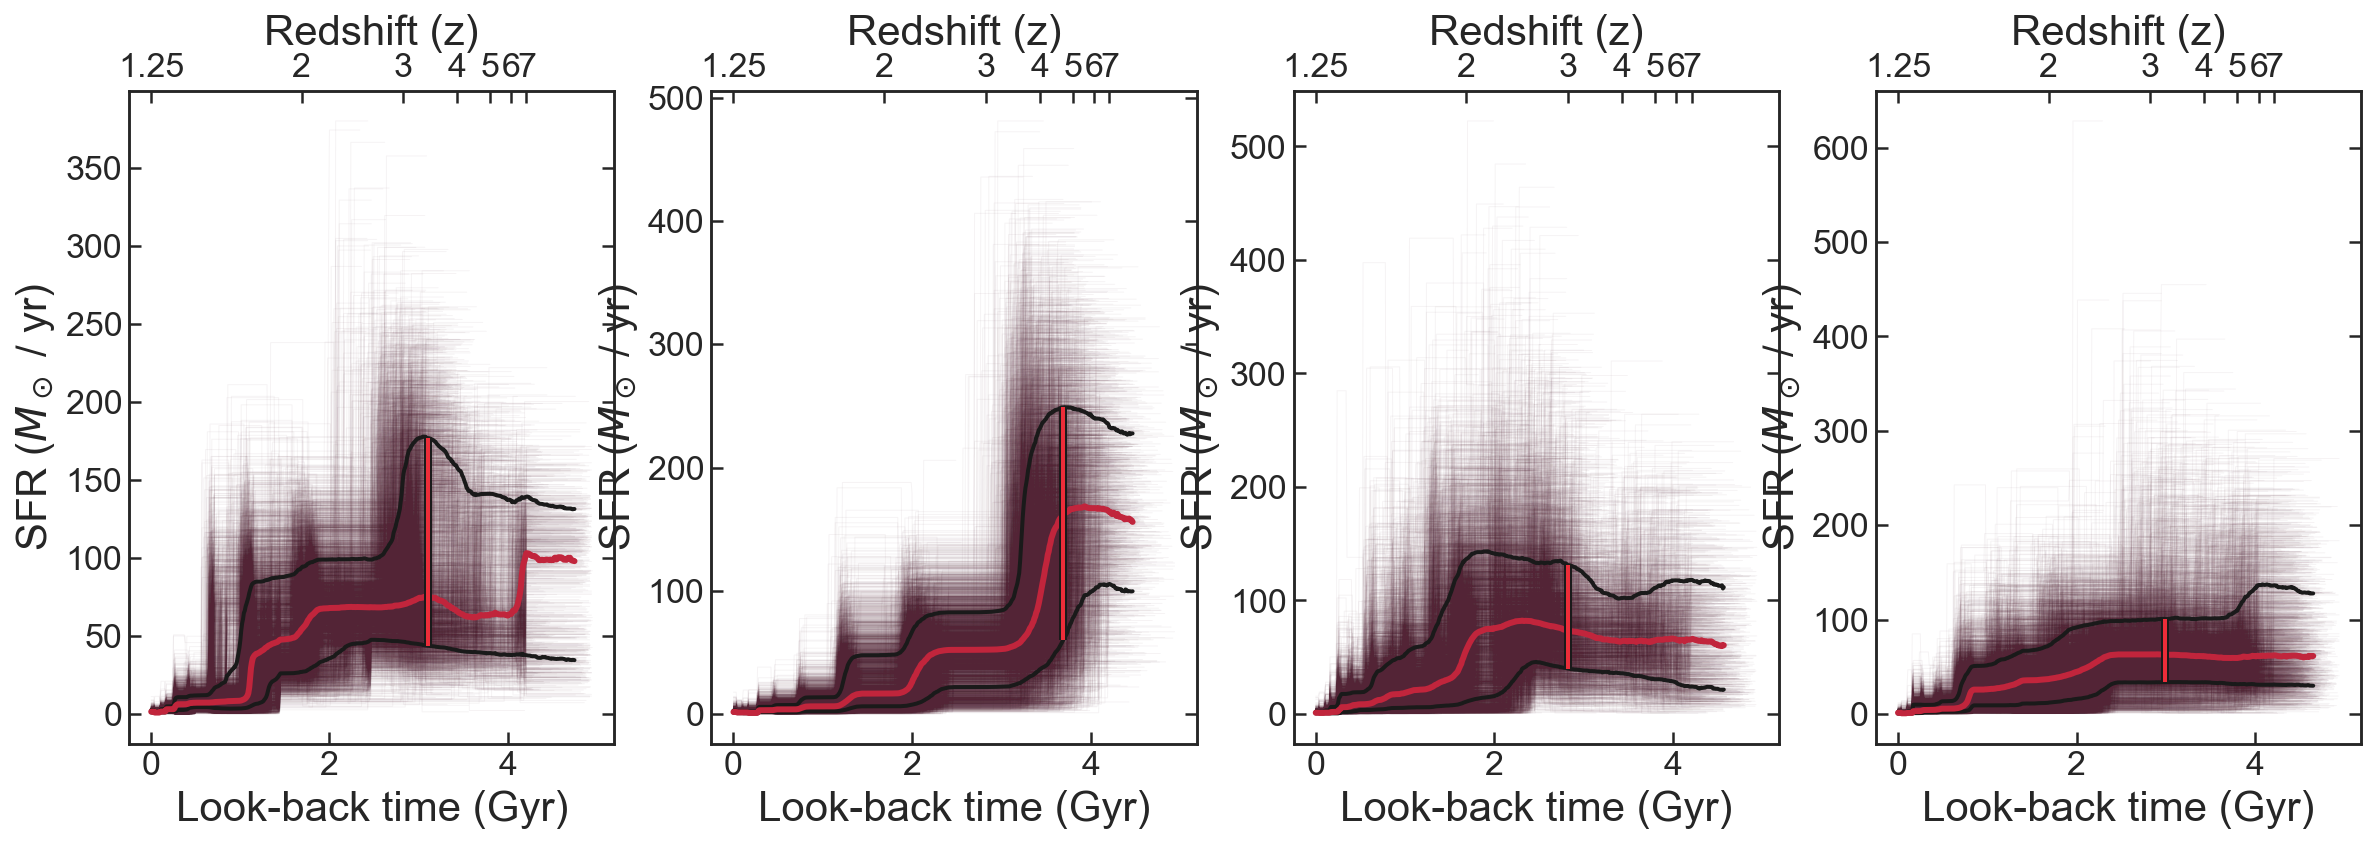

In [8]:
gs = gridspec.GridSpec(1,4)


plt.figure(figsize=[20,6])
ax3 = plt.subplot(gs[0])

isfhl = interp1d(sfh1.LBT,sfh1.SFH_16)
isfhh = interp1d(sfh1.LBT,sfh1.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh1.fulltimes, sfh1.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh1.LBT,sfh1.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh1.LBT,sfh1.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh1.LBT,sfh1.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh1.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(bfz).value
age_at_z = cosmo.lookback_time(bfz).value
zarray = [np.round(bfz,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh1.t_50,isfhl(sfh1.t_50), isfhh(sfh1.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh1.t_50,isfhl(sfh1.t_50), isfhh(sfh1.t_50), color = 'k', linewidth = 4, zorder = 10)

########################
ax3 = plt.subplot(gs[1])

isfhl = interp1d(sfh2.LBT,sfh2.SFH_16)
isfhh = interp1d(sfh2.LBT,sfh2.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh2.fulltimes, sfh2.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh2.LBT,sfh2.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh2.LBT,sfh2.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh2.LBT,sfh2.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh2.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(bfz).value
age_at_z = cosmo.lookback_time(bfz).value
zarray = [np.round(bfz,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh2.t_50,isfhl(sfh2.t_50), isfhh(sfh2.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh2.t_50,isfhl(sfh2.t_50), isfhh(sfh2.t_50), color = 'k', linewidth = 4, zorder = 10)

#######################
ax3 = plt.subplot(gs[2])

isfhl = interp1d(sfh3.LBT,sfh3.SFH_16)
isfhh = interp1d(sfh3.LBT,sfh3.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh3.fulltimes, sfh3.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh3.LBT,sfh3.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh3.LBT,sfh3.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh3.LBT,sfh3.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh3.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(bfz).value
age_at_z = cosmo.lookback_time(bfz).value
zarray = [np.round(bfz,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh3.t_50,isfhl(sfh3.t_50), isfhh(sfh3.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh3.t_50,isfhl(sfh3.t_50), isfhh(sfh3.t_50), color = 'k', linewidth = 4, zorder = 10)

#######################
ax3 = plt.subplot(gs[3])

isfhl = interp1d(sfh4.LBT,sfh4.SFH_16)
isfhh = interp1d(sfh4.LBT,sfh4.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh4.fulltimes, sfh4.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh4.LBT,sfh4.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh4.LBT,sfh4.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh4.LBT,sfh4.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh4.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(bfz).value
age_at_z = cosmo.lookback_time(bfz).value
zarray = [np.round(bfz,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh4.t_50,isfhl(sfh4.t_50), isfhh(sfh4.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh4.t_50,isfhl(sfh4.t_50), isfhh(sfh4.t_50), color = 'k', linewidth = 4, zorder = 10)

In [ ]:
gs = gridspec.GridSpec(1,5)
plt.figure(figsize=[20,6])

ax1 = plt.subplot(gs[0])
x,Px = np.load('../data/posteriors/GND_21156_tabfit_Pm.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit1_Pm.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit5_Pm.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit6_Pm.npy')
plt.plot(x,Px)
plt.xlabel('Z/Z$_\odot$')

ax2 = plt.subplot(gs[1])
x,Px = np.load('../data/posteriors/GND_21156_tabfit_Plwa.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit1_Plwa.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit5_Plwa.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit6_Plwa.npy')
plt.plot(x,Px)
plt.xlabel('LWA (Gyr)')

ax3 = plt.subplot(gs[2])
x,Px = np.load('../data/posteriors/GND_21156_tabfit_Pz.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit1_Pz.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit5_Pz.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit6_Pz.npy')
plt.plot(x,Px)
plt.xlabel('Redshift (z)')

ax4 = plt.subplot(gs[3])
x,Px = np.load('../data/posteriors/GND_21156_tabfit_Pd.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit1_Pd.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit5_Pd.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit6_Pd.npy')
plt.plot(x,Px)
plt.xlabel('Dust (Av)')

ax5 = plt.subplot(gs[4])
x,Px = np.load('../data/posteriors/GND_21156_tabfit_Plm.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit1_Plm.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit5_Plm.npy')
plt.plot(x,Px)
x,Px = np.load('../data/posteriors/GND_21156_tabMfit6_Plm.npy')
plt.plot(x,Px)
plt.xlabel('log(M/M$_\odot$)')


# SF galaxy

In [10]:
Gs = Gen_SF_spec('GND', 11839, 1.2402) 
mb_g102_sf, mb_g141_sf = Gen_multibeams('../data/multifit_data/gdn-grism-j123656p6215_14138.beams.fits')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self

1 ib3706b2q_flt.fits G141
2 ib3706b6q_flt.fits G141
3 ib3706biq_flt.fits G141
4 ib3706bpq_flt.fits G141
5 ib3707caq_flt.fits G141
6 ib3707ceq_flt.fits G141
7 ib3707cqq_flt.fits G141
8 ib3707cuq_flt.fits G141
9 ib3746tuq_flt.fits G141
10 ib3746ujq_flt.fits G141
11 ib3746urq_flt.fits G141
12 ib3746uxq_flt.fits G141
13 ib3747a5q_flt.fits G141
14 ib3747z0q_flt.fits G141
15 ib3747z5q_flt.fits G141
16 ib3747zyq_flt.fits G141
17 icat06gqq_flt.fits G102
18 icat07bxq_flt.fits G102
19 icat07c2q_flt.fits G102
20 icat07c9q_flt.fits G102
21 icat07ceq_flt.fits G102
22 icxt36jmq_flt.fits G102
23 icxt36jnq_flt.fits G102
24 icxt36jqq_flt.fits G102
25 icxt36jsq_flt.fits G102
26 icxt37laq_flt.fits G102
27 icxt37lbq_flt.fits G102
28 icxt37leq_flt.fits G102
29 icxt37lgq_flt.fits G102
30 icxt38p6q_flt.fits G102
31 icxt38p7q_flt.fits G102
32 icxt38paq_flt.fits G102
33 icxt38pcq_flt.fits G102
34 icxt39eoq_flt.fits G102
35 icxt39epq_flt.fits G102
36 icxt39esq_flt.fits G102
37 icxt39euq_flt.fits G102
38 icxt40n

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  s

In [13]:
field = 'GSD'
galaxy = 45068

beams = '../data/multifit_data/{}_{}.beams.fits'.format(field, galaxy)

mb_g102_sf, mb_g141_sf = Gen_multibeams(beams, args = args)

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

###########gen spec##########
Gs = Gen_SF_spec(field, galaxy, 1, phot_errterm = 0.04, irac_err = 0.08) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 ibhj03xoq_flt.fits G141
2 ibhj03xvq_flt.fits G141
3 ibhj03y2q_flt.fits G141
4 ibhj03y9q_flt.fits G141
5 ibhj11hiq_flt.fits G141
6 ibhj11hpq_flt.fits G141
7 ibhj11hwq_flt.fits G141
8 ibhj11i3q_flt.fits G141
9 icxt01cgq_flt.fits G102
10 icxt01ciq_flt.fits G102
11 icxt01clq_flt.fits G102
12 icxt01cnq_flt.fits G102
13 icxt02c7q_flt.fits G102
14 icxt02caq_flt.fits G102
15 icxt02cdq_flt.fits G102
16 icxt02cfq_flt.fits G102
17 icxt03jjq_flt.fits G102
18 icxt03jkq_flt.fits G102
19 icxt03jnq_flt.fits G102
20 icxt03jpq_flt.fits G102
21 icxt04e3q_flt.fits G102
22 icxt04edq_flt.fits G102
23 icxt04efq_flt.fits G102
24 icxt05h7q_flt.fits G102
25 icxt05h9q_flt.fits G102
26 icxt05hcq_flt.fits G102
27 icxt05heq_flt.fits G102
28 icxt06laq_flt.fits G102
29 icxt06lcq_flt.fits G102
30 icxt06lfq_flt.fits G102
31 icxt06lhq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2922: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((fl-er*0.)[clip], 5))
/Users/vestrada/minicon

[Text(0,0,'0.8'),
 Text(0,0,'1'),
 Text(0,0,'1.2'),
 Text(0,0,'1.4'),
 Text(0,0,'1.6')]

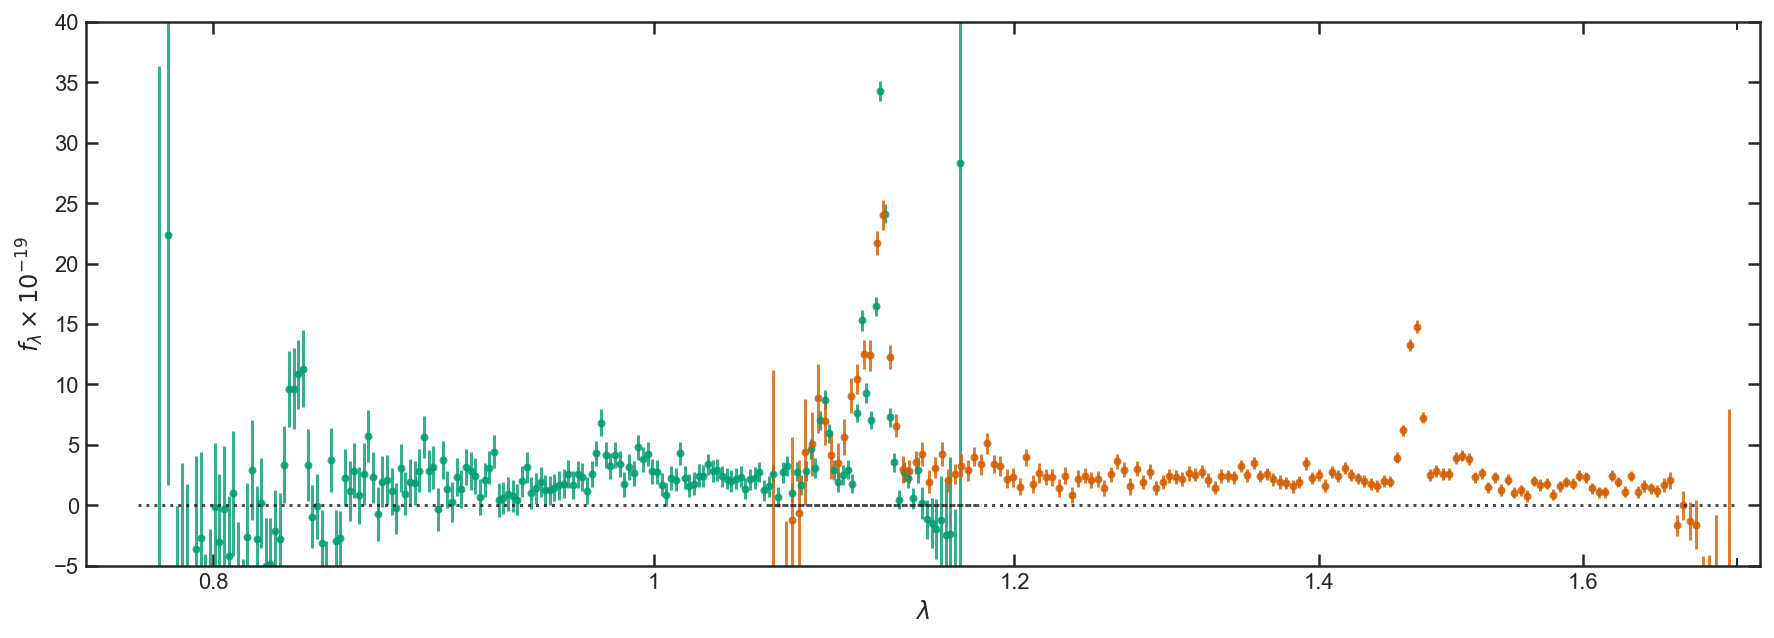

In [64]:
fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(111)

mb_g102_sf.oned_figure(show_beams=False, axc=ax1)
mb_g141_sf.oned_figure(show_beams=False, axc=ax1)

ax1.set_xlim(.75,1.75)
ax1.set_ylim(-5,40)
ax1.set_xticks([0.8,1,1.2,1.4,1.6])
ax1.set_xticklabels([0.8,1,1.2,1.4,1.6])

In [65]:
SF_temps = Gen_temp_dict(1.2403, lowlim = 8000, hilim = 16000)

SF_temps

{'line ArIII-7138': <grizli.utils.SpectrumTemplate at 0x1a758cc2b0>,
 'line H10': <grizli.utils.SpectrumTemplate at 0x1a758cf860>,
 'line H7': <grizli.utils.SpectrumTemplate at 0x1a758cf358>,
 'line H8': <grizli.utils.SpectrumTemplate at 0x1a758cf518>,
 'line H9': <grizli.utils.SpectrumTemplate at 0x1a758cf6d8>,
 'line Ha': <grizli.utils.SpectrumTemplate at 0x1a758cc5f8>,
 'line Hb': <grizli.utils.SpectrumTemplate at 0x1a758ccc50>,
 'line Hd': <grizli.utils.SpectrumTemplate at 0x1a758cf198>,
 'line HeI-5877': <grizli.utils.SpectrumTemplate at 0x1a758cc908>,
 'line Hg': <grizli.utils.SpectrumTemplate at 0x1a758ccf98>,
 'line NeIII-3867': <grizli.utils.SpectrumTemplate at 0x1a758cf9e8>,
 'line OI-6302': <grizli.utils.SpectrumTemplate at 0x1a758cc780>,
 'line OII': <grizli.utils.SpectrumTemplate at 0x1a758cfb70>,
 'line OIII': <grizli.utils.SpectrumTemplate at 0x1a758cca90>,
 'line OIII-4363': <grizli.utils.SpectrumTemplate at 0x1a758ccdd8>,
 'line SII': <grizli.utils.SpectrumTemplate at 

In [66]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)

bfm, bfa, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfd, bfz, bflogz = np.load('../data/posteriors/GSD_45068_SFMfit_bfit.npy')

wave, flux = Gen_model(sp, [bfm, bfa, bfd], [bfm1, bfm2, bfm3, bfm4, bfm5, bfm6], agebins = 6, SF = True)

In [17]:
wave0 = 4000
SF_temps['fsps_model'] = SpectrumTemplate(wave, flux)
SF_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)

In [18]:
g102_fit = mb_g102_sf.template_at_z(bfz, templates = SF_temps, fitter = 'lstsq')
g141_fit = mb_g141_sf.template_at_z(bfz, templates = SF_temps, fitter = 'lstsq')

wv_obs, flx = spec_construct(g102_fit, g141_fit, bfz)
iflux = interp1d(wave*(1+bfz), flux)(wv_obs[flx**2 > 0])

flam = F_lam_per_M(flx * (iflux[50]/flx[50]),wv_obs, bfz, 0, sp.stellar_mass)
Pmfl = Gs.Sim_phot_mult(wv_obs,flam)
scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [19]:
g102_fit['cfit'],g102_fit['chi2'], mb_g102_sf.DoF

(OrderedDict([('bg 000', (0.004132973496164961, 0.0010445645670114872)),
              ('bg 001', (0.004009799748891964, 0.000959491144878759)),
              ('bg 002', (0.002939202641917528, 0.0009815832120376896)),
              ('bg 003', (0.0031148228053054297, 0.0009102964819039346)),
              ('bg 004', (0.0017783064888323916, 0.0010269879728692715)),
              ('bg 005', (0.0015345339164125685, 0.0009534743793941298)),
              ('bg 006', (0.0032140609454762853, 0.000997363192023805)),
              ('bg 007', (0.002773275463043949, 0.0009189189529871655)),
              ('bg 008', (0.0007437606627691482, 0.000975633608491454)),
              ('bg 009', (0.0021076537587904967, 0.0010214315345540373)),
              ('bg 010', (0.001373422745723392, 0.0009013150425372375)),
              ('bg 011', (0.0031534066678482464, 0.0009471549368107698)),
              ('bg 012', (0.004831902781987016, 0.0009661604849975895)),
              ('bg 013', (0.0027262756744173486

In [20]:
g141_fit['cfit'],g141_fit['chi2'],mb_g141_sf.DoF

(OrderedDict([('bg 000', (-0.00698356158981106, 0.001247389118519853)),
              ('bg 001', (-0.0056667004755945535, 0.0011141665910366434)),
              ('bg 002', (-0.003538707257845712, 0.0012273732720442508)),
              ('bg 003', (-0.004531855865024061, 0.0011157314882560621)),
              ('bg 004', (-0.001698475532387382, 0.0014906765430142777)),
              ('bg 005', (-0.00485551025878371, 0.001802245581272855)),
              ('bg 006', (-0.0004934507715492129, 0.0014599036691628025)),
              ('bg 007', (-0.002017894823457135, 0.0017048965936296103)),
              ('fsps_model_slope',
               (-3.1531976858949893e-14, 3.750816879313754e-15)),
              ('line OIII', (2.8208490670662597e-16, 1.8816236555241972e-16)),
              ('line OI-6302', (0.0, 0.0)),
              ('line SII', (0.0, 0.0)),
              ('line ArIII-7138', (0.0, 0.0)),
              ('line Hd', (-2.2034447688479077e-17, 6.660955180128144e-18)),
              ('line O

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)


[Text(0,0,'5000'), Text(0,0,'10000'), Text(0,0,'50000')]

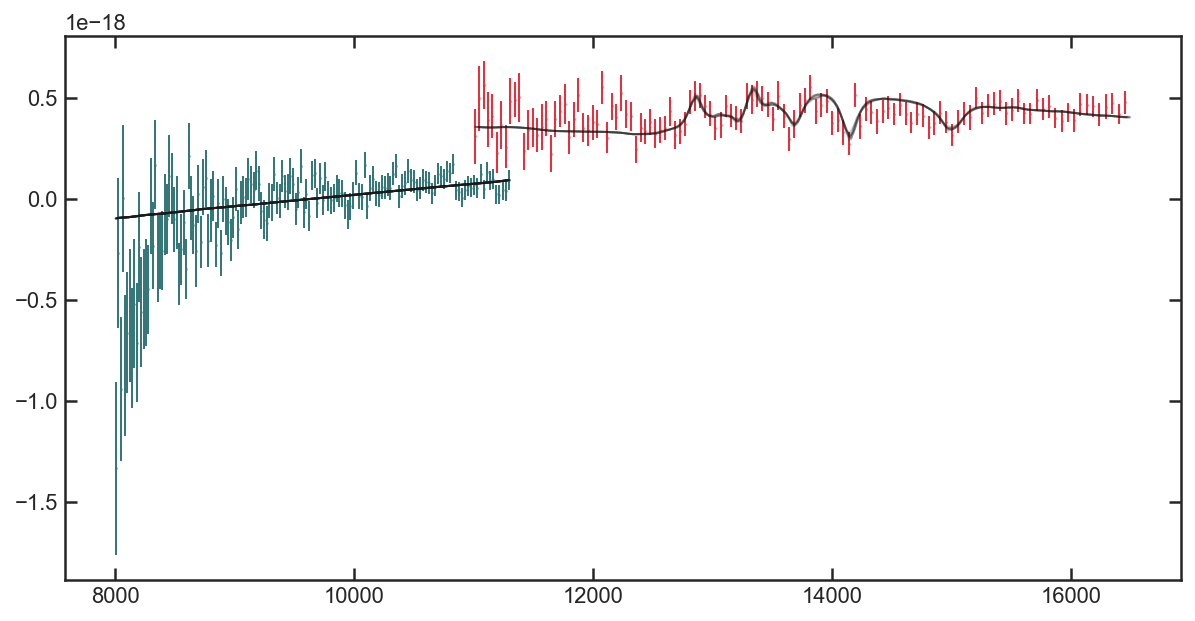

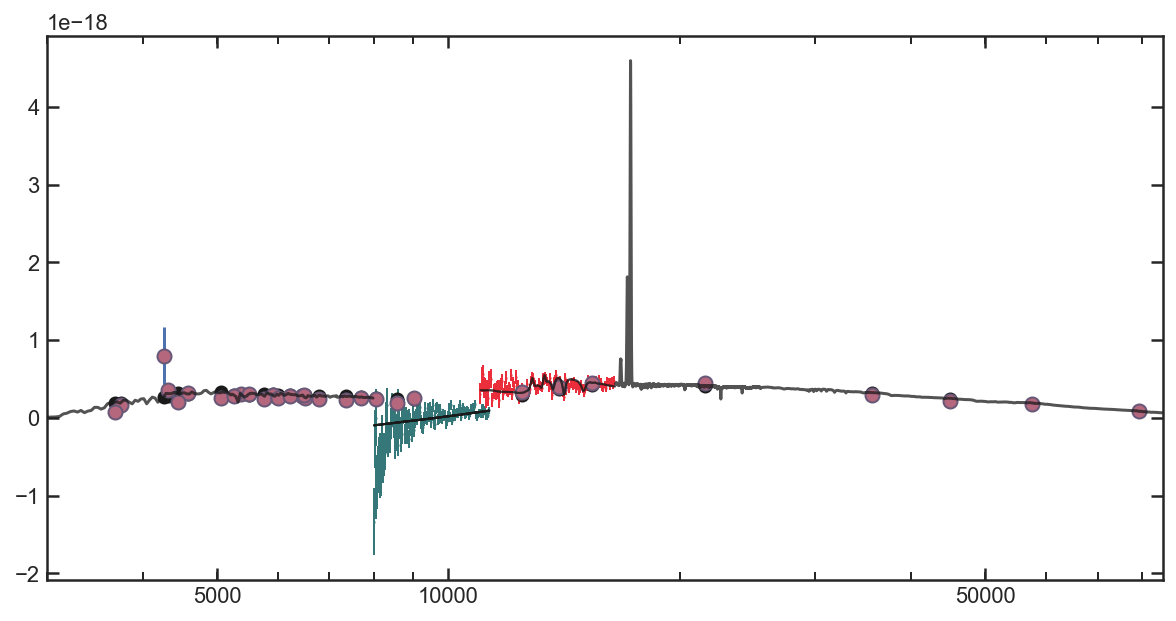

In [21]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot()
Plot_grism_fit(mb_g102_sf, g102_fit, 'G102', ax, '#36787A', [8000,11300])
Plot_grism_fit(mb_g141_sf, g141_fit, 'G141', ax, '#EA2E3B', [11000,16500])

fig = plt.figure(figsize=[10,5])
ax = plt.subplot()
Plot_grism_fit(mb_g102_sf, g102_fit, 'G102', ax, '#36787A', [8000,11300])
Plot_grism_fit(mb_g141_sf, g141_fit, 'G141', ax, '#EA2E3B', [11000,16500])

ax.errorbar(Gs.Pwv,Gs.Pflx,Gs.Perr,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
ax.scatter(Gs.Pwv, scl*Pmfl, color = 'k', marker='o')

IDB = [U for U in range(len(wv_obs)) if wv_obs[U] < 8000]
IDR = [U for U in range(len(wv_obs)) if wv_obs[U] > 16500]

ax.plot(wv_obs[IDB], flam[IDB]*scl,'k', alpha = 0.75, zorder=5)
ax.plot(wv_obs[IDR], flam[IDR]*scl,'k', alpha = 0.75)

ax.set_xscale('log')
ax.set_xlim(3000,85000)
ax.set_xticks([5000,10000,50000])
ax.set_xticklabels([5000,10000,50000])

# get spec

In [4]:
mb_g102_sf, mb_g141_sf = Gen_multibeams('../data/multifit_data/gds-grism-j033236m2748_57935.beams.fits')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 ibhj03xoq_flt.fits G141
2 ibhj03xvq_flt.fits G141
3 ibhj03y2q_flt.fits G141
4 ibhj03y9q_flt.fits G141
5 ibhj11hiq_flt.fits G141
6 ibhj11hpq_flt.fits G141
7 ibhj11hwq_flt.fits G141
8 ibhj11i3q_flt.fits G141
9 icxt01cgq_flt.fits G102
10 icxt01ciq_flt.fits G102
11 icxt01clq_flt.fits G102
12 icxt01cnq_flt.fits G102
13 icxt02c7q_flt.fits G102
14 icxt02caq_flt.fits G102
15 icxt02cdq_flt.fits G102
16 icxt02cfq_flt.fits G102
17 icxt03jjq_flt.fits G102
18 icxt03jkq_flt.fits G102
19 icxt03jnq_flt.fits G102
20 icxt03jpq_flt.fits G102
21 icxt04e3q_flt.fits G102
22 icxt04edq_flt.fits G102
23 icxt04efq_flt.fits G102
24 icxt05h7q_flt.fits G102
25 icxt05h9q_flt.fits G102
26 icxt05hcq_flt.fits G102
27 icxt05heq_flt.fits G102
28 icxt06laq_flt.fits G102
29 icxt06lcq_flt.fits G102
30 icxt06lfq_flt.fits G102
31 icxt06lhq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = n

In [36]:
from spec_extract import Stack
def Extract_spec(field, galaxy):
    if field[1] == 'N':
        pre = 'N'
    else:
        pre = 'S'
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*.1D.fits'.format(pre, galaxy))
    print(spec_list)
    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')

    if len(Bwv) > 0:                
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
        np.save('../Casey_data/spec/{0}_{1}_g102'.format(field, galaxy),[SBW, SBF, SBE, SBT, SBL, SBC])


    if len(Rwv) > 0:     
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
        np.save('../Casey_data/spec/{0}_{1}_g141'.format(field, galaxy),[SRW, SRF, SRE, SRT, SRL, SRC])


In [37]:
Extract_spec('GSD', 45068)

['/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS2/GS2_45068.1D.fits', '/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS3/GS3_45068.1D.fits']
no g102


/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:41: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:48: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:49: RuntimeWarning: invalid value encountered in double_scalars
  stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:50: RuntimeWarning: invalid value encountered in double_scalars
  stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:51: RuntimeWarning: invalid value encountered in double_scalars
  stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_fiel

In [12]:
def load_beams_and_trns(wv, field, galaxy_id, instr):
    ### Set transmission curve
    sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.002/0.019), 
                                sfh = 4, tau = 0.6, dust_type = 1)

    model_wave, model_flux = sp.get_spectrum(tage = 3.6, peraa = True)

    ### set beams
    BEAMS = []

    blist = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*{}*/*{}*'.format(field[1], galaxy_id) )

    for b in blist:    
        mb = multifit.MultiBeam(b,**args, verbose = False)

        PAlist = []

        for bm in mb.beams:
            if bm.grism.filter == instr:
                if bm.get_dispersion_PA() not in BPAlist:
                    PAlist.append(bm.get_dispersion_PA())
                    BEAMS.append(bm)

    TRANS = []

    for i in BEAMS:
        W, F = forward_model_grism(i, model_wave, np.ones(len(model_wave)))
        trans = interp1d(W,F)(wv)       
        TRANS.append(trans)

    return BEAMS, TRANS

In [13]:
print(blist)

['/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GN2/GN2_17436.beams.fits', '/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GN7/GN7_17436.beams.fits']


In [7]:
N_beams = pd.read_pickle('../dataframes/galaxy_frames/GN_buldge_insamp.pkl')

for i in N_beams.index:
    blist = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*N*/*{}*'.format(N_beams.id[i]) )
    for b in blist:
        mb_g102, mb_g141 = Gen_multibeams(b)

        pa = -1
        for bm in mb_g102.beams:
            if bm.grism.filter == 'G102':
                if pa != bm.get_dispersion_PA():
                    pa = bm.get_dispersion_PA()
                    bm.write_fits(root='../beams/o{0}'.format(pa), overwrite=True)
                    fits.setval('../beams/o{0}_{1}.{2}.A.fits'.format(pa, N_beams.id[i], bm.grism.filter), 'EXPTIME', ext=0,
                            value=fits.open('../beams/o{0}_{1}.{2}.A.fits'.format(pa, N_beams.id[i], bm.grism.filter))[1].header['EXPTIME'])   

        pa = -1            
        for bm in mb_g141.beams:
            if bm.grism.filter == 'G141':
                if pa != bm.get_dispersion_PA():
                    pa = bm.get_dispersion_PA()
                    bm.write_fits(root='../beams/o{0}'.format(pa), overwrite=True)
                    fits.setval('../beams/o{0}_{1}.{2}.A.fits'.format(pa, N_beams.id[i], bm.grism.filter), 'EXPTIME', ext=0,
                            value=fits.open('../beams/o{0}_{1}.{2}.A.fits'.format(pa, N_beams.id[i], bm.grism.filter))[1].header['EXPTIME'])   

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 icat07bxq_flt.fits G102
2 icat07c2q_flt.fits G102
3 icat07c9q_flt.fits G102
4 icat07ceq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 icxt36jmq_flt.fits G102
6 icxt36jnq_flt.fits G102
7 icxt36jqq_flt.fits G102
8 icxt36jsq_flt.fits G102
9 ib3707caq_flt.fits G141
10 ib3707ceq_flt.fits G141
11 ib3707cqq_flt.fits G141
12 ib3707cuq_flt.fits G141
13 ib3747z0q_flt.fits G141
14 ib3747z5q_flt.fits G141
15 ib3747zyq_flt.fits G141
16 ib3747a5q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = n

1 icat07bxq_flt.fits G102
2 icat07c2q_flt.fits G102
3 icat07c9q_flt.fits G102
4 icat07ceq_flt.fits G102
5 icxt36jmq_flt.fits G102
6 icxt36jnq_flt.fits G102
7 icxt36jqq_flt.fits G102
8 icxt36jsq_flt.fits G102
9 ib3707caq_flt.fits G141
10 ib3707ceq_flt.fits G141
11 ib3707cqq_flt.fits G141
12 ib3707cuq_flt.fits G141
13 ib3747z0q_flt.fits G141
14 ib3747z5q_flt.fits G141
15 ib3747zyq_flt.fits G141
16 ib3747a5q_flt.fits G141
1 icat07bxq_flt.fits G102
2 icat07c2q_flt.fits G102
3 icat07c9q_flt.fits G102
4 icat07ceq_flt.fits G102
5 icxt37laq_flt.fits G102
6 icxt37lbq_flt.fits G102
7 icxt37leq_flt.fits G102
8 icxt37lgq_flt.fits G102
9 icxt38p6q_flt.fits G102
10 icxt38p7q_flt.fits G102
11 icxt38paq_flt.fits G102
12 icxt38pcq_flt.fits G102
13 ib3707caq_flt.fits G141
14 ib3707ceq_flt.fits G141
15 ib3707cqq_flt.fits G141
16 ib3707cuq_flt.fits G141
17 ib3747z0q_flt.fits G141
18 ib3747z5q_flt.fits G141
19 ib3747zyq_flt.fits G141
20 ib3747a5q_flt.fits G141
1 icat07bxq_flt.fits G102
2 icat07c2q_flt.fits

KeyError: 'g141'

In [7]:
Gs = Gen_SF_spec('GSD', 45068, 2.4491, phot_errterm = 0.04, irac_err = 0.08) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  sel

<ErrorbarContainer object of 3 artists>

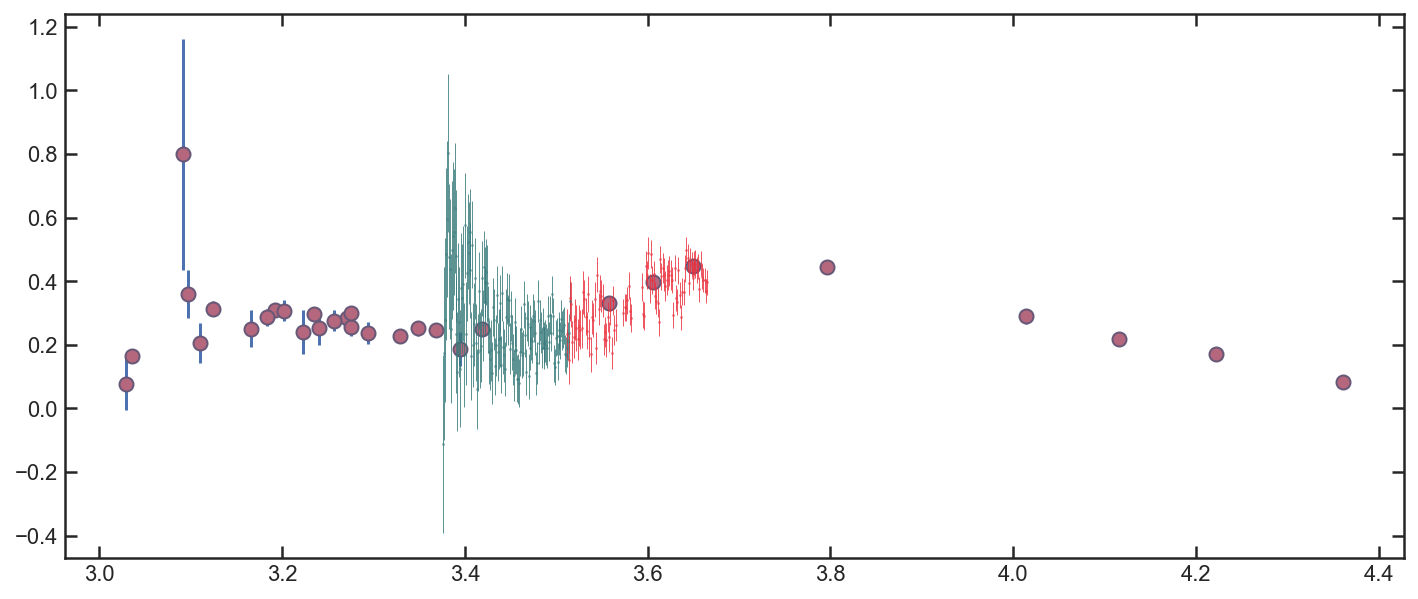

In [9]:
plt.figure(figsize=[12,5])

plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)


plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)


plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
    linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
         markeredgecolor = '#685877',markeredgewidth = 1)

# set tilt

In [30]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, dust_type = 2)

wave, flux = sp.get_spectrum(tage = 0.1, peraa = True)

In [31]:
wave0 = 4000
Tflux=flux*(wave-wave0)/wave0

(-1, 2)

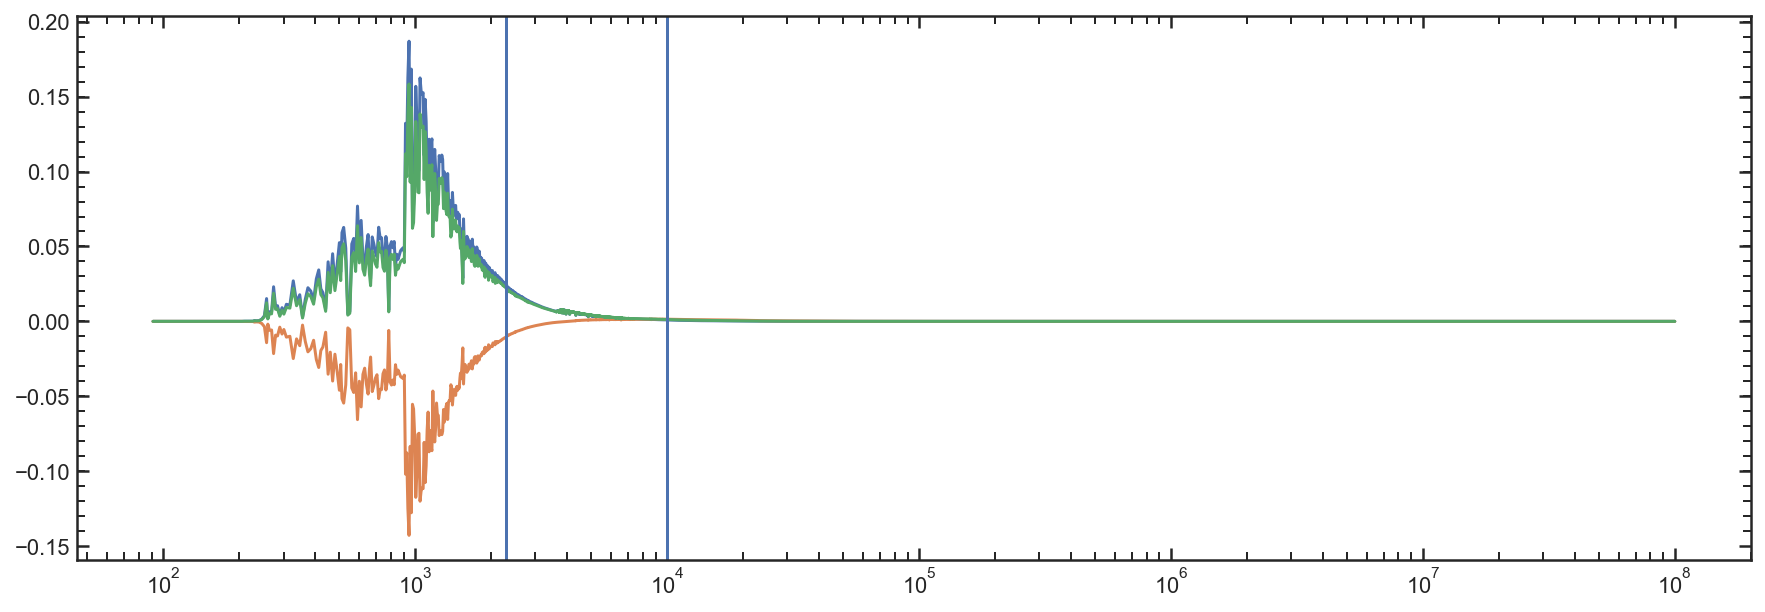

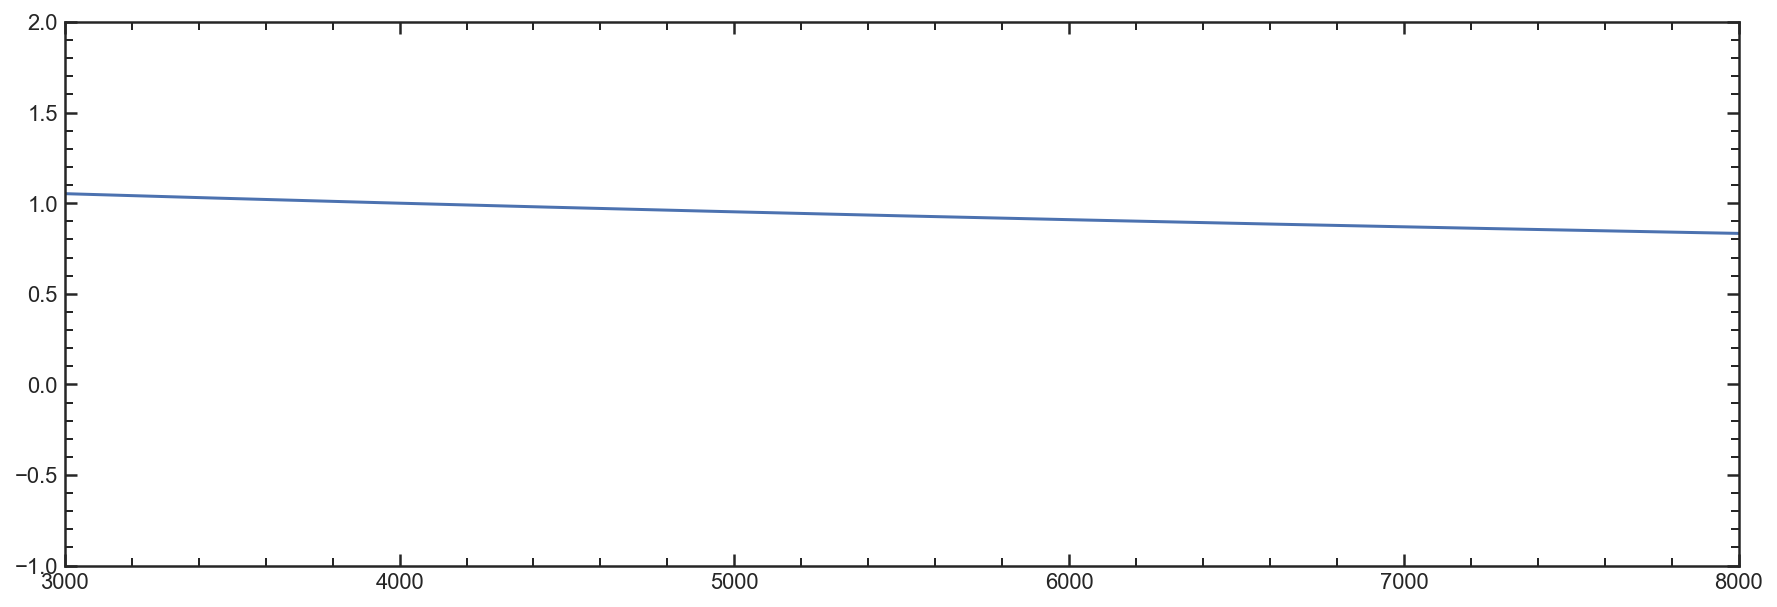

In [32]:
plt.figure(figsize=[15,5])
plt.plot(wave,flux)
# plt.xscale('log')

# plt.figure(figsize=[15,5])
plt.plot(wave,Tflux)
plt.xscale('log')
plt.plot(wave,(flux + 0.2*Tflux))
plt.axvline(17000 / 1.7)
plt.axvline(8000 / (3.5))

plt.figure(figsize=[15,5])
plt.plot(wave,flux / (flux + 0.2*Tflux))
plt.xlim(3000,8000)
plt.ylim(-1,2)
# plt.xscale('log')


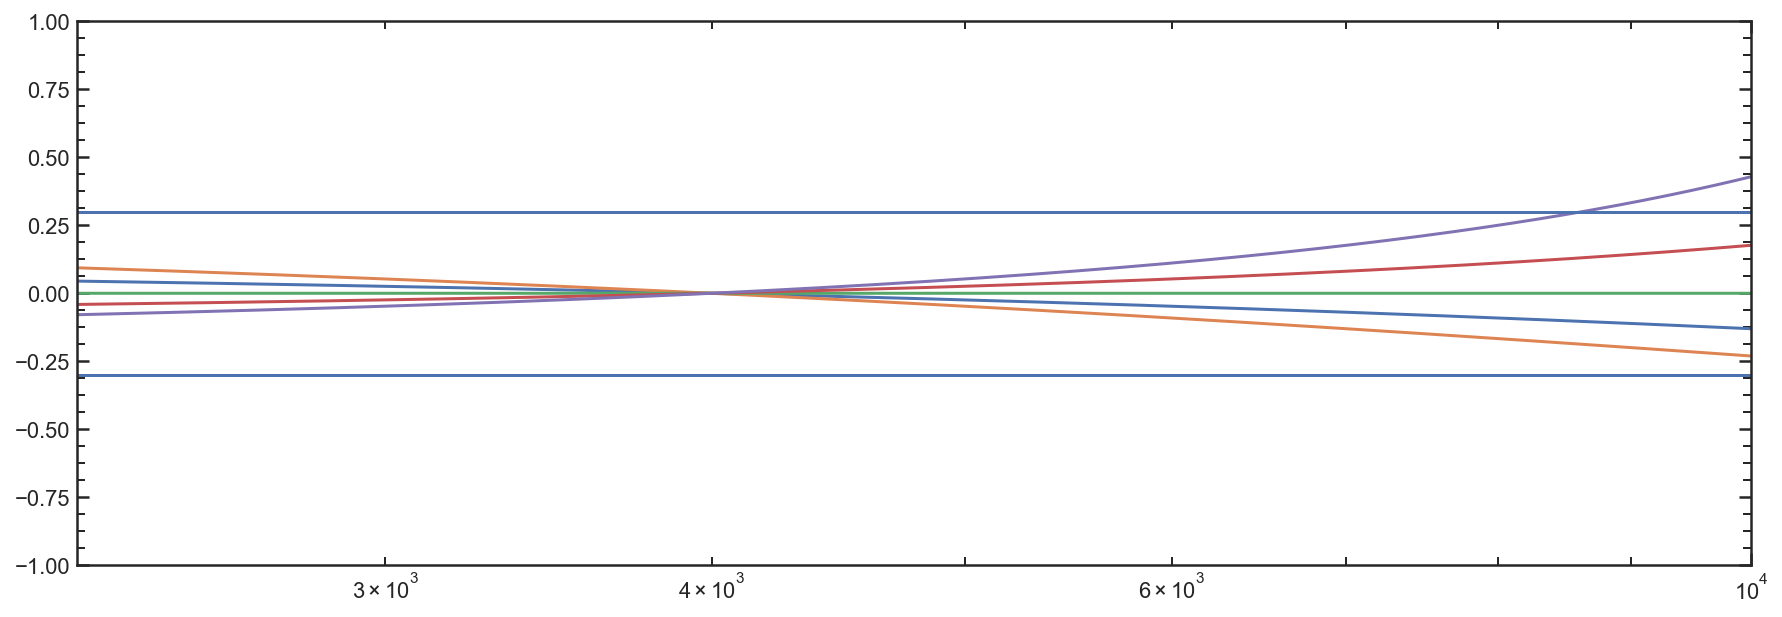

In [33]:
plt.figure(figsize=[15,5])
plt.plot(wave,flux / (flux + 0.1*Tflux) - 1)
plt.plot(wave,flux / (flux + 0.2*Tflux) - 1)
plt.plot(wave,flux / (flux + 0.0*Tflux) - 1)
plt.plot(wave,flux / (flux - 0.1*Tflux) - 1)
plt.plot(wave,flux / (flux - 0.2*Tflux) - 1)
# plt.plot(wave,flux / (flux - 0.25*Tflux) - 1)
plt.xlim(8000 / (3.5),17000 / 1.7)
plt.ylim(-1,1)
plt.xscale('log')
plt.axhline(-0.3)
plt.axhline(0.3)

In [19]:
6.34E-14/1.91E-14

3.3193717277486914

In [9]:
def spec_construct(g102_fit,g141_fit, z, wave0 = 4000, usetilt = True):
    flat = np.ones_like(g141_fit['cont1d'].wave)
    slope = flat*(g141_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g141_fit['cfit']['fsps_model'][0]+slope * g141_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g141_fit['cont1d'].flux / tilt

    line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
    untilted_line_g141 = untilted_continuum*(1+line_g141)

    flat = np.ones_like(g102_fit['cont1d'].wave)
    slope = flat*(g102_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g102_fit['cfit']['fsps_model'][0]+slope * g102_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g102_fit['cont1d'].flux / tilt

    line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
    untilted_line_g102 = untilted_continuum*(1+line_g102)

    FL = np.append(untilted_line_g102[g102_fit['cont1d'].wave <= 12000],untilted_line_g141[g102_fit['cont1d'].wave > 12000])
    return g102_fit['cont1d'].wave, FL

def spec_construct(g102_fit,g141_fit, z, wave0 = 4000, usetilt = True):
    flat = np.ones_like(g141_fit['cont1d'].wave)
    slope = flat*(g141_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g141_fit['cfit']['fsps_model'][0]+slope * g141_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g141_fit['cont1d'].flux / tilt

    line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
    untilted_line_g141 = untilted_continuum*(1+line_g141)

    flat = np.ones_like(g102_fit['cont1d'].wave)
    slope = flat*(g102_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g102_fit['cfit']['fsps_model'][0]+slope * g102_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g102_fit['cont1d'].flux / tilt

    line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
    untilted_line_g102 = untilted_continuum*(1+line_g102)

    FL = np.append(untilted_line_g102[g102_fit['cont1d'].wave <= 12000],untilted_line_g141[g102_fit['cont1d'].wave > 12000])
    return g102_fit['cont1d'].wave, FL

In [11]:
wave0 = 4000
SF_temps =  Gen_temp_dict(1.25, 8000, 16000)

In [15]:
sb = 0.1
sr = 0.05

SF_temps['fsps_model'] = SpectrumTemplate(wave, flux + sb*flux*(wave-wave0)/wave0)    
g102_fit = mb_g102_sf.template_at_z(1.25, templates = SF_temps, fitter='lstsq')
    
SF_temps['fsps_model'] = SpectrumTemplate(wave, flux + sr*flux*(wave-wave0)/wave0)    
g141_fit = mb_g141_sf.template_at_z(1.25, templates = SF_temps, fitter='lstsq')

In [ ]:
wv_obs, flx = spec_construct(g102_fit,g141_fit,z)

Pmfl = Gs.Sim_phot_mult(wv_obs, flx)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(8000, 17800)

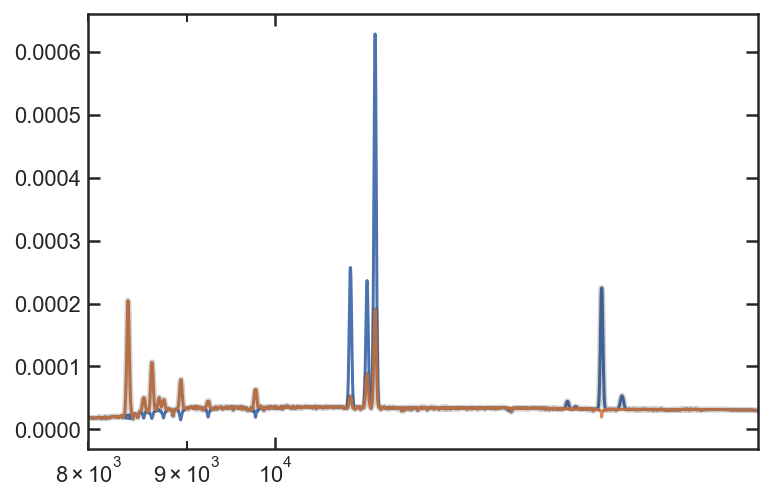

In [59]:
z=1.25
def spec_construct(g102_fit,g141_fit, z, sb, sr, wave0 = 4000, usetilt = True):
    flat = np.ones_like(g141_fit['cont1d'].wave) # ones array
    slope = (g141_fit['cont1d'].wave/(1+z)-wave0)/wave0 # slope without coeff 
    tilt = g141_fit['cfit']['fsps_model'][0]*(flat + (slope * sr)) # scaling up and slope coeff
    untilted_continuum = g141_fit['cont1d'].flux / tilt # return to fsps scale
    line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
    untilted_line_g141 = untilted_continuum*(1+line_g141)


    flat = np.ones_like(g102_fit['cont1d'].wave)
    slope = (g102_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = g102_fit['cfit']['fsps_model'][0]*(flat + slope * sb)
    untilted_continuum = g102_fit['cont1d'].flux / tilt

    line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
    untilted_line_g102 = untilted_continuum*(1+line_g102)

    FL = np.append(untilted_line_g102[g102_fit['cont1d'].wave <= 12000],untilted_line_g141[g102_fit['cont1d'].wave > 12000])

    return g102_fit['cont1d'].wave, FL

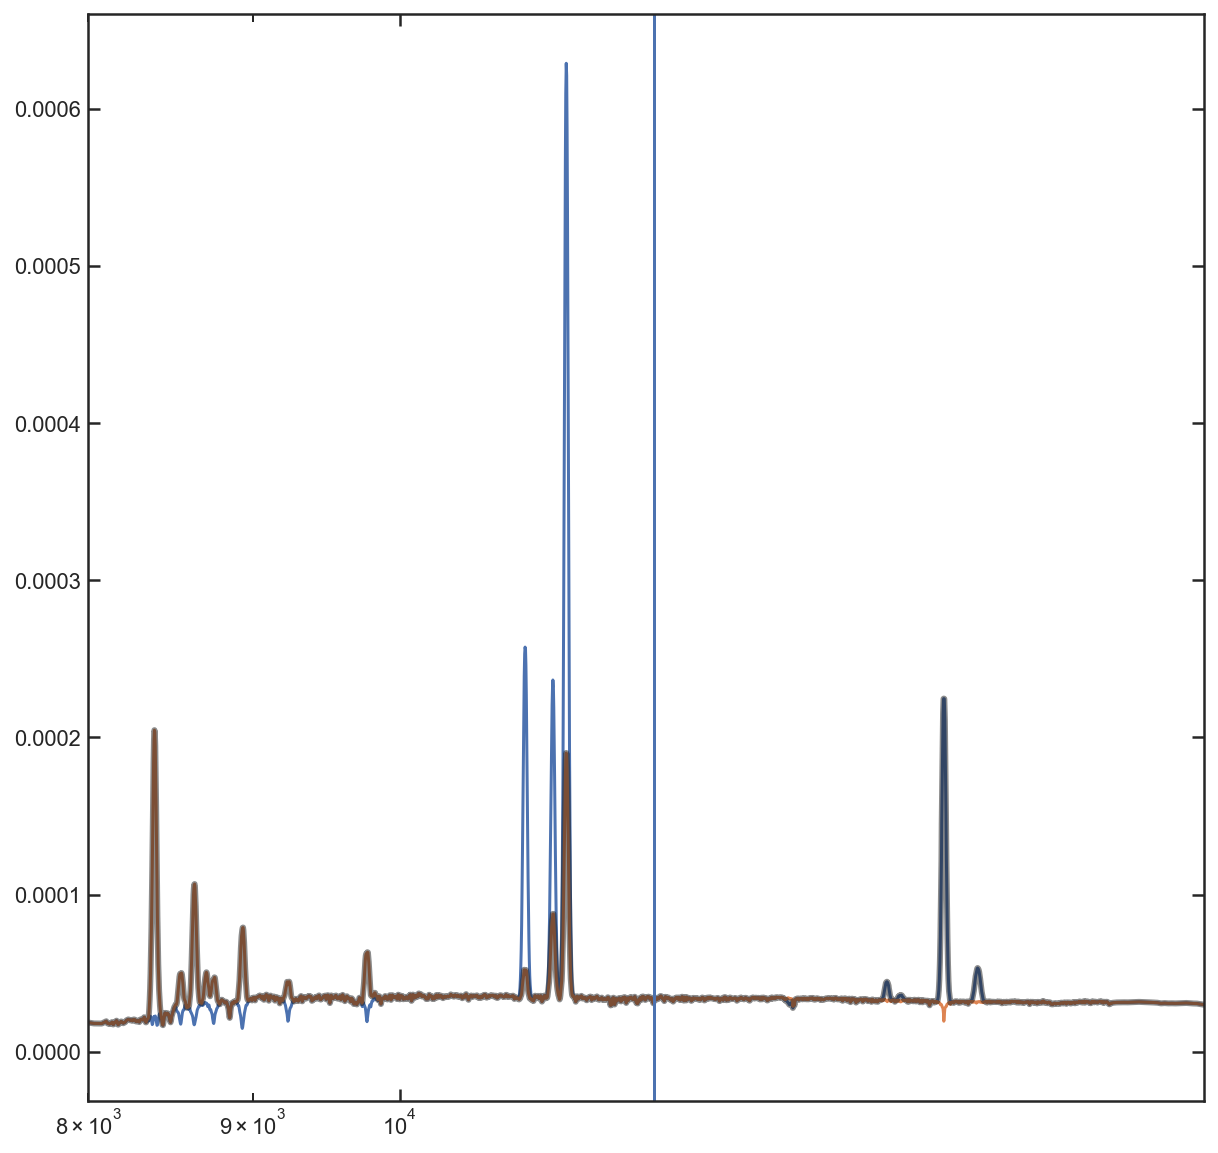

In [63]:

plt.figure(figsize=[10,10])
plt.plot(g141_fit['cont1d'].wave, untilted_line_g141)
plt.plot(g102_fit['cont1d'].wave, untilted_line_g102)
plt.plot(g102_fit['cont1d'].wave, FL, 'k', linewidth = 3, alpha = 0.5)

plt.xscale('log')
plt.xlim(8000,17800)
plt.axvline(12000)

# generate lwa and lmass posterior

In [4]:
dres = np.load('../chidat/GND_21156_tabMfit7.npy').item()

In [5]:
from spec_id import get_agebins
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def get_lwa(params, agebins,sp):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = params

    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(agebins, [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10])

    sp.set_tabular_sfh(time,sfr)    
    
    sp.params['compute_light_ages'] = True
    lwa = sp.get_mags(tage = a, bands=['sdss_g'])
    sp.params['compute_light_ages'] = False
    
    return lwa

def Get_derived_posterior(sample, results):
    logwt = results.logwt
    logz = results.logz
    
    
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [12]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

start = time()
lwa = []
for i in range(len(dres.samples)):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, sb, sr = dres.samples[i]
    lwa.append(get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0])
end = time()
print(end - start) 

In [27]:
x,px = Get_lwa_posterior(np.array(lwa), dres)

# sea.distplot(lwa)
plt.plot(x,px)

x,px = np.load('../data/posteriors/GND_21156_tabMfit7_Plwa.npy')
plt.plot(x,px)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Plwa.npy')
plt.plot(x,px)

In [29]:
x,px = Get_lwa_posterior(np.array(lwa), dres)
Highest_density_region(px,x)

(2.131590862142596, [1.751680660808928, 2.3952932371859657], array([0.]))

In [2]:
from sim_engine import F_lam_per_M
GS = Gen_spec('GND', 21156, 1.25)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 icat21cfq_flt.fits G102
2 icat21coq_flt.fits G102
3 icat21dgq_flt.fits G102
4 icat21dlq_flt.fits G102
5 icxt55krq_flt.fits G102
6 icxt55ksq_flt.fits G102
7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3721xiq_flt.fits G141
26 ib3721xmq_flt.fits G141
27 ib3721xyq_flt.fits G141
28 ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = n

1 icat25hcq_flt.fits G102
2 icat25hiq_flt.fits G102
3 icat25icq_flt.fits G102
4 icat25iiq_flt.fits G102
5 ib3725dyq_flt.fits G141
6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_f

1 icat21cfq_flt.fits G102
2 icat21coq_flt.fits G102
3 icat21dgq_flt.fits G102
4 icat21dlq_flt.fits G102
5 icxt55krq_flt.fits G102
6 icxt55ksq_flt.fits G102
7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3721xiq_flt.fits G141
26 ib3721xmq_flt.fits G141
27 ib3721xyq_flt.fits G141
28 ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  s

1 icat25hcq_flt.fits G102
2 icat25hiq_flt.fits G102
3 icat25icq_flt.fits G102
4 icat25iiq_flt.fits G102
5 ib3725dyq_flt.fits G141
6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [9]:
from time import time as tm
start = tm()

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
lm = []
for i in range(len(dres.samples)):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, sb, sr = dres.samples[i]

    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 

    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    flam = F_lam_per_M(flux, wave * (1+z), z, 0, sp.stellar_mass)
    Pmfl = GS.Sim_phot_mult(wave * (1 + z),flam)
    scl = Scale_model(GS.Pflx, GS.Perr, Pmfl)
    lm.append(np.log10(scl))
    
end = tm()
print(end - start) 

135.70454597473145


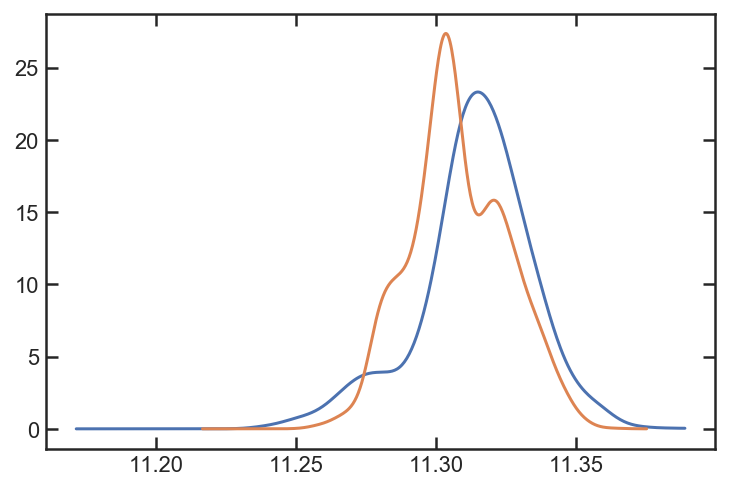

In [15]:
x,px = Get_lwa_posterior(np.array(lm), dres)

# sea.distplot(lm)
plt.plot(x,px)

# x,px = np.load('../data/posteriors/GND_21156_tabMfit7_Plm.npy')
# plt.plot(x,px)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Plm.npy')
plt.plot(x,px)

generate line posterior

In [4]:
dres = np.load('../chidat/GSD_45068_SFMfit.npy').item()

In [7]:
beams = mfit_path + 'GSD_45068.beams.fits'

mb_g102, mb_g141 = Gen_multibeams(beams, args = args)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 ibhj03xoq_flt.fits G141
2 ibhj03xvq_flt.fits G141
3 ibhj03y2q_flt.fits G141
4 ibhj03y9q_flt.fits G141
5 ibhj11hiq_flt.fits G141
6 ibhj11hpq_flt.fits G141
7 ibhj11hwq_flt.fits G141
8 ibhj11i3q_flt.fits G141
9 icxt01cgq_flt.fits G102
10 icxt01ciq_flt.fits G102
11 icxt01clq_flt.fits G102
12 icxt01cnq_flt.fits G102
13 icxt02c7q_flt.fits G102
14 icxt02caq_flt.fits G102
15 icxt02cdq_flt.fits G102
16 icxt02cfq_flt.fits G102
17 icxt03jjq_flt.fits G102
18 icxt03jkq_flt.fits G102
19 icxt03jnq_flt.fits G102
20 icxt03jpq_flt.fits G102
21 icxt04e3q_flt.fits G102
22 icxt04edq_flt.fits G102
23 icxt04efq_flt.fits G102
24 icxt05h7q_flt.fits G102
25 icxt05h9q_flt.fits G102
26 icxt05hcq_flt.fits G102
27 icxt05heq_flt.fits G102
28 icxt06laq_flt.fits G102
29 icxt06lcq_flt.fits G102
30 icxt06lfq_flt.fits G102
31 icxt06lhq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = n

In [10]:
SF_temps =  Gen_temp_dict(2.4491, 8000, 16000)
wave0 = 4000

In [31]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0
B_lines = {}
R_lines = {}
for k in SF_temps:
    if k[0] == 'l':
        B_lines[k] = []
        R_lines[k] = []

for i in range(len(dres.samples)):
    m, a, m1, m2, m3, m4, m5, m6, d, z, sb, sr = dres.samples[i]
    wave, flux = Gen_model(sp, [m, a, d], [m1, m2, m3, m4, m5, m6], agebins = 6, SF = True)
    
    SF_temps['fsps_model'] = SpectrumTemplate(wave, flux + sb*flux*(wave-wave0)/wave0)    
    g102_fit = mb_g102.template_at_z(z, templates = SF_temps, fitter='lstsq')
    
    SF_temps['fsps_model'] = SpectrumTemplate(wave, flux + sr*flux*(wave-wave0)/wave0)    
    g141_fit = mb_g141.template_at_z(z, templates = SF_temps, fitter='lstsq')
    
    for k in B_lines:
        B_lines[k].append(g102_fit['cfit'][k][0])
    
    for k in R_lines:
        R_lines[k].append(g141_fit['cfit'][k][0])

for k in B_lines:
    if sum(B_lines[k]) > 0:
        x,px = Get_derived_posterior(np.array(B_lines[k]), dres)
        plt.title(k)
        
    if sum(R_lines[k]) > 0:
        x,px = Get_derived_posterior(np.array(R_lines[k]), dres)
        plt.title(k)

# Examine all galaxies

In [97]:
GS_fls = glob('../beams/*S*.beams.fits')
GN_fls = glob('../beams/*N*.beams.fits')

In [98]:
GS_ids = [os.path.basename(U).strip('.beams.fits').split('_')[1] for U in GS_fls]
GN_ids = [os.path.basename(U).strip('.beams.fits').split('_')[1] for U in GN_fls]

In [117]:
mdb = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')
sfdb = pd.read_pickle('../Casey_data/SF_db_p1.pkl')
Bdb = pd.read_pickle('../dataframes/fitdb/buldgefitsdb.pkl')

sfdb = sfdb.rename(columns={'zgrism': 'z_grizli'})

adb = pd.concat([mdb,sfdb,Bdb])
fadb = adb.drop_duplicates(subset=['field', 'id'])
fadb = fadb.sort_values(['field', 'id'])
fadb = fadb.reset_index()
alldb = fadb[['field', 'id', 'zgrism', 'z_grizli', 'lmass']]
Qdb = alldb.query('zgrism > 0')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [617]:
temps = {}
for k in args['t1']:
    if k[0] == 'f' or k[5:] in ['Ha', 'Hb', 'Hg', 'Hd'] :
        temps[k] = args['t1'][k]

In [543]:
em_gals = [14746,14784,15178,15490,18603,21156,23435,28451,32108,35728,36596,37813,23421,25641,26915,28119,30587,36482,37739,39170,41886,42820,44946,45789,45994]
em_fld = ['GND','GND','GND','GND','GND','GND','GND','GND','GND','GND','GND','GND','GSD','GSD','GSD','GSD','GSD','GSD','GSD','GSD','GSD','GSD','GSD','GSD','GSD']
lines = [['Ha'],['Ha'],['Ha'],['Ha'],['Hd'],['Ha'],['Ha'],['Ha'],['Ha'],['Ha'],['Ha'],['Ha'],['Ha'],
         ['Hb','OIII','Ha','SII'],['OIII','Ha'],['Ha'],['Ha'],['Ha'],['Ha'],['Ha'],['OIII'],['OII'],['Ha'],['OIII','Ha'],['Ha']]

emlines = []
for idx in alldb.index:
    inline = False
    for i in range(len(em_gals)):
        if alldb.field[idx] == em_fld[i] and alldb.id[idx] == em_gals[i]: 
            emlines.append(lines[i])
            inline = True
            
    if not inline:
        emlines.append([])

In [545]:
alldb['Qlines'] = emlines

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [546]:
alldb

,field,id,zgrism,z_grizli,lmass,Qlines
0,GND,10639,NaN,1.265857,9.163849,[]
1,GND,11279,-99.000000,1.220616,10.471450,[]
2,GND,11460,-99.000000,0.557419,10.367308,[]
3,GND,11814,1.692009,NaN,10.393400,[]
4,GND,11839,NaN,1.240109,9.730826,[]
5,GND,12078,1.016371,NaN,10.797066,[]
6,GND,12451,1.010006,NaN,10.365516,[]
7,GND,12478,1.223559,NaN,10.392782,[]
8,GND,12481,0.663151,NaN,10.557659,[]
9,GND,12617,0.930914,NaN,9.835416,[]


In [459]:
idx = Qdb.index[257]

fl = glob('../beams/*{}*{}*.beams.fits'.format(Qdb.field[idx][1], Qdb.id[idx]))[0]

mb = multifit.MultiBeam(fl,**args)

print(Qdb.zgrism[idx])
fit = mb.template_at_z(Qdb.zgrism[idx], templates = temps, fitter='lstsq')

for k in fit['cfit']:
    if fit['cfit'][k][0] > 0 and k[0] == 'l':
        print(k,fit['cfit'][k])

fig = mb.oned_figure(show_beams=False, tfit=fit)
plt.axvline(0.4102 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.4341 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.4862 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.6564 *(1 + Qdb.zgrism[idx]), color = 'r')

KeyError: 1

In [274]:
#     grism_beams = {}
#     for g in mb.PA:
#         grism_beams[g.lower()] = []
#         for pa in mb.PA[g]:
#             for i in mb.PA[g][pa]:
#                 grism_beams[g.lower()].append(mb.beams[i])

#     mb_g102 = multifit.MultiBeam(grism_beams['g102'], fcontam=mb.fcontam, 
#                                  min_sens=mb.min_sens, min_mask=mb.min_mask, 
#                                  group_name=mb.group_name+'-g102')
#     # bug, will be fixed ~today to not have to do this in the future
#     for b in mb_g102.beams:
#         if hasattr(b, 'xp'):
#             delattr(b, 'xp')
#     mb_g102.initialize_masked_arrays()

#     mb_g141 = multifit.MultiBeam(grism_beams['g141'], fcontam=mb.fcontam, 
#                                  min_sens=mb.min_sens, min_mask=mb.min_mask, 
#                                  group_name=mb.group_name+'-g141')
#     # bug, will be fixed ~today to not have to do this in the future
#     for b in mb_g141.beams:
#         if hasattr(b, 'xp'):
#             delattr(b, 'xp')
#     mb_g141.initialize_masked_arrays()

0.38785046728971956

In [559]:
len(mb.beams)

42

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 icat08hiq_flt.fits G102
2 icat08hnq_flt.fits G102
3 icat08huq_flt.fits G102
4 icat08hzq_flt.fits G102
5 ib3708i5q_flt.fits G141
6 ib3708i9q_flt.fits G141
7 ib3708ilq_flt.fits G141
8 ib3708ipq_flt.fits G141
9 ib3748v8q_flt.fits G141
10 ib3748vdq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  s

1 icat07bxq_flt.fits G102
2 icat07c2q_flt.fits G102
3 icat07c9q_flt.fits G102
4 icat07ceq_flt.fits G102
5 icxt39eoq_flt.fits G102
6 icxt39epq_flt.fits G102
7 icxt39esq_flt.fits G102
8 icxt39euq_flt.fits G102
9 icxt40npq_flt.fits G102
10 icxt40nrq_flt.fits G102
11 icxt40nuq_flt.fits G102
12 icxt40nwq_flt.fits G102
13 icxt37laq_flt.fits G102
14 icxt37lbq_flt.fits G102
15 icxt37leq_flt.fits G102
16 icxt37lgq_flt.fits G102
17 icxt38p6q_flt.fits G102
18 icxt38p7q_flt.fits G102
19 icxt38paq_flt.fits G102
20 icxt38pcq_flt.fits G102
21 icxt36jmq_flt.fits G102
22 icxt36jnq_flt.fits G102
23 icxt36jqq_flt.fits G102
24 icxt36jsq_flt.fits G102
25 ib3707caq_flt.fits G141
26 ib3707ceq_flt.fits G141
27 ib3707cqq_flt.fits G141
28 ib3707cuq_flt.fits G141
29 ib3747z0q_flt.fits G141
30 ib3747z5q_flt.fits G141
31 ib3747zyq_flt.fits G141
32 ib3747a5q_flt.fits G141
1.01623537173367


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/mini

1.0577475462167107


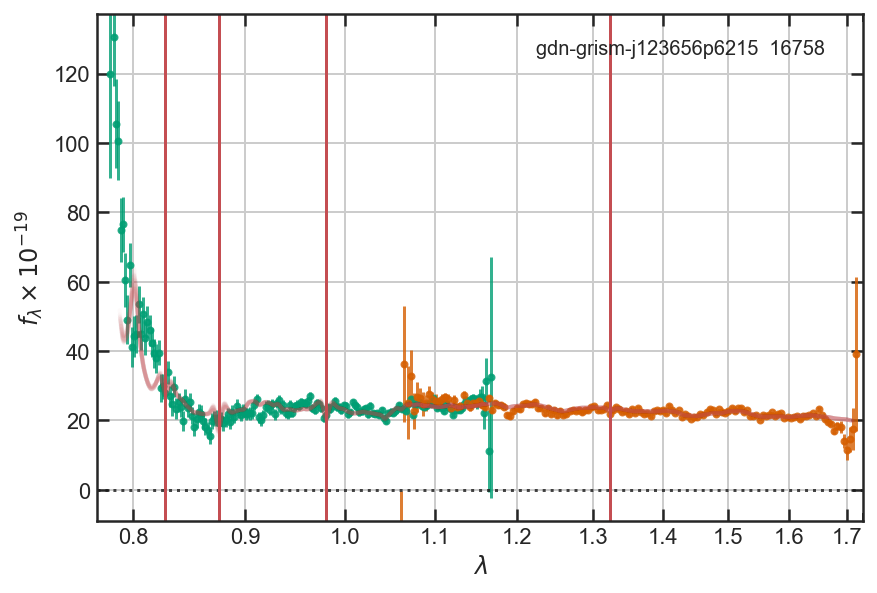

In [558]:
idx = alldb.query('id == 16758').index.values[0]

fl = glob('../beams/*{}*{}*.beams.fits'.format(alldb.field[idx][1], alldb.id[idx]))

blist = []
for f in fl:
    mb = multifit.MultiBeam(f,**args)
    for bm in mb.beams:
        blist.append(bm)
        
mb = multifit.MultiBeam(blist,**args)
        
print(alldb.zgrism[idx])
fit = mb.template_at_z(alldb.zgrism[idx], templates = temps, fitter='lstsq')
print(fit['chi2']/mb.DoF)
for k in fit['cfit']:
    if fit['cfit'][k][0] > 0 and k[0] == 'l':
        print(k,fit['cfit'][k])

fig = mb.oned_figure(show_beams=False, tfit=fit)
plt.axvline(0.4102 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.4341 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.4862 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.6564 *(1 + Qdb.zgrism[idx]), color = 'r')


In [764]:
alldb

,field,id,zgrism,z_grizli,lmass,Qlines
0,GND,10639,NaN,1.265857,9.163849,[]
1,GND,11279,-99.000000,1.220616,10.471450,[]
2,GND,11460,-99.000000,0.557419,10.367308,[]
3,GND,11814,1.692009,NaN,10.393400,[]
4,GND,11839,NaN,1.240109,9.730826,[]
5,GND,12078,1.016371,NaN,10.797066,[]
6,GND,12451,1.010006,NaN,10.365516,[]
7,GND,12478,1.223559,NaN,10.392782,[]
8,GND,12481,0.663151,NaN,10.557659,[]
9,GND,12617,0.930914,NaN,9.835416,[]


In [916]:
idx = alldb.index[53]

if alldb.zgrism[idx] > 0:
    rshift = alldb.zgrism[idx] 
else:
    rshift = alldb.z_grizli[idx] 
    

fl = glob('../beams/*{}*{}*.beams.fits'.format(alldb.field[idx][1], alldb.id[idx]))

blist = []
for f in fl:
    mb = multifit.MultiBeam(f,**args)
    for bm in mb.beams:
        blist.append(bm)
        
mb = multifit.MultiBeam(blist,**args)

for b in mb.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb.initialize_masked_arrays()

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 icat25hcq_flt.fits G102
2 icat25hiq_flt.fits G102
3 icat25icq_flt.fits G102
4 icat25iiq_flt.fits G102
5 ib3725dyq_flt.fits G141
6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:1497: RuntimeWarning: invalid value encountered in sqrt
  sivarf = self.sivarf*np.sqrt(self.weightf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/l

1.1158413462232741


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:3013: RuntimeWarning: divide by zero encountered in true_divide
  unit_corr = 1./sp_flat[g]['flux']/1.e-19#/pscale
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:3015: RuntimeWarning: invalid value encountered in multiply
  flux = (sp_data[g]['flux']*unit_corr/pscale)[clip]
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:3016: RuntimeWarning: invalid value encountered in multiply
  err = (sp_data[g]['err']*unit_corr/pscale)[clip]
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1

[]
[] []
[]
1.1158413462232741


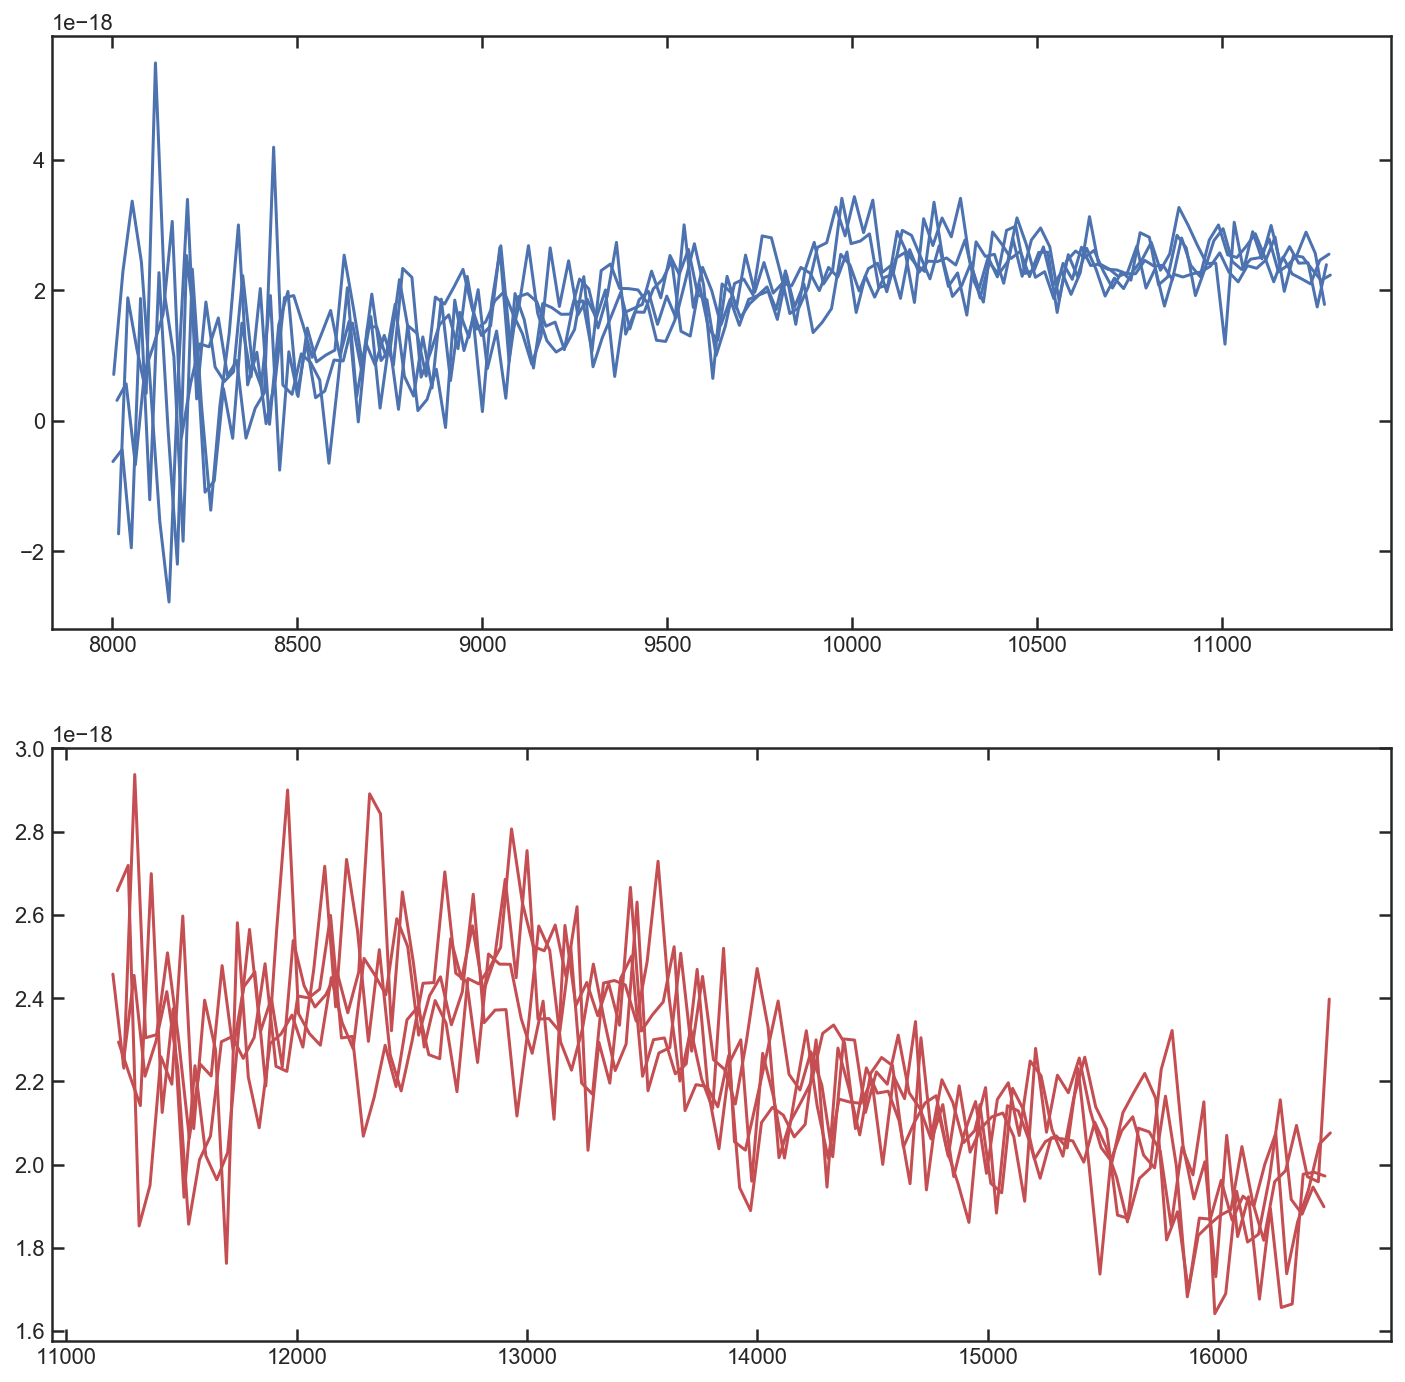

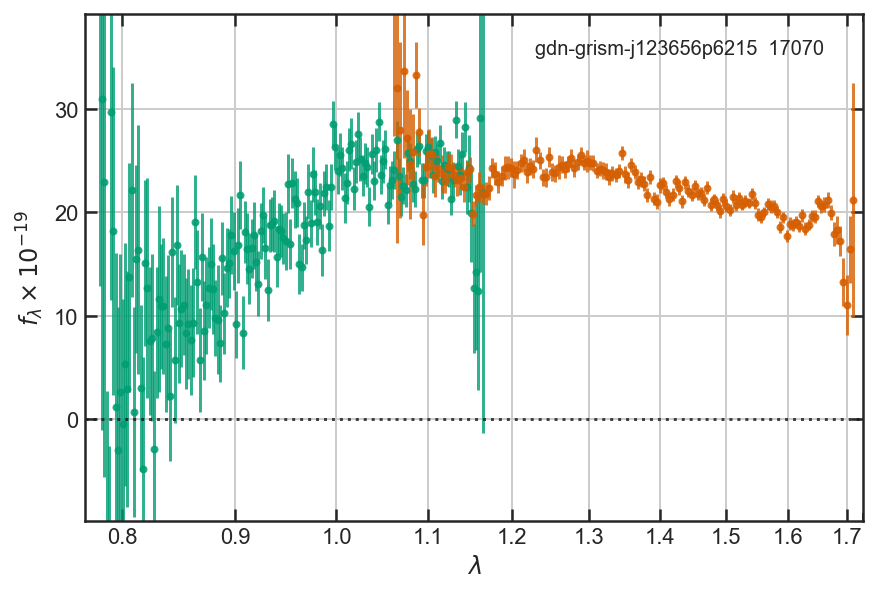

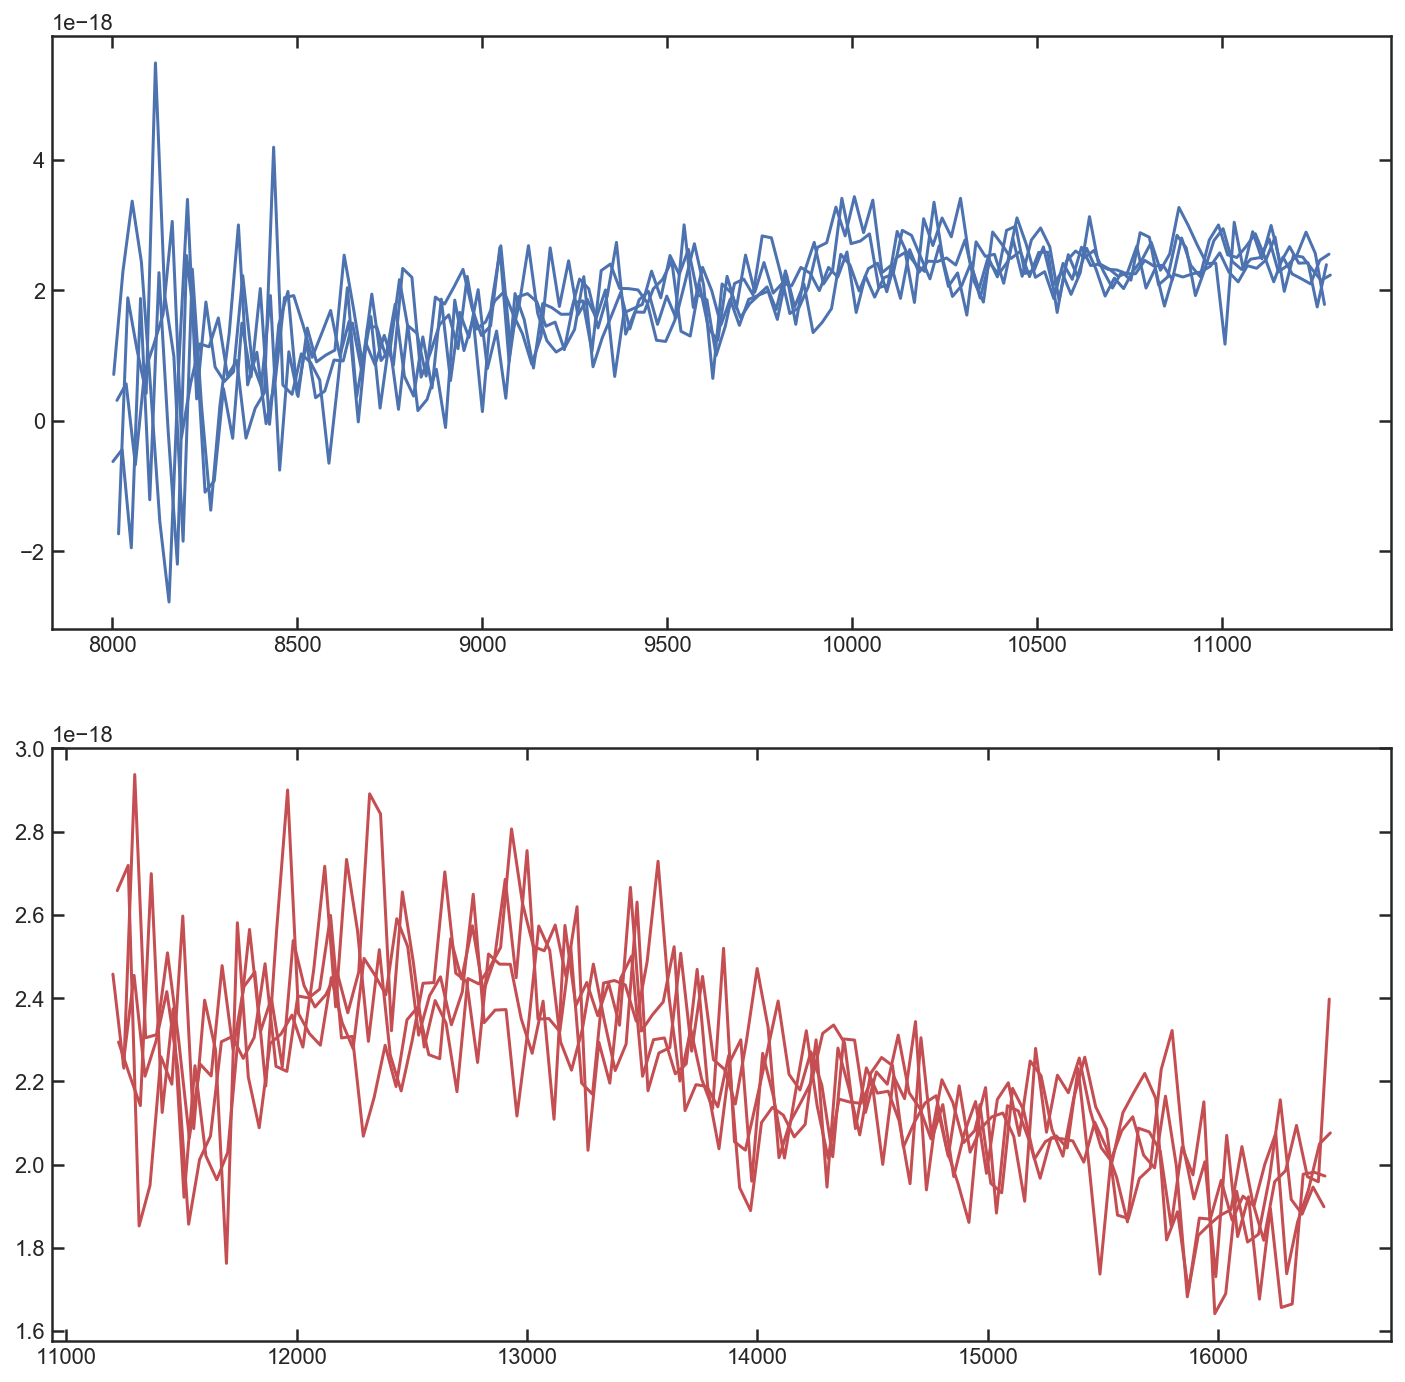

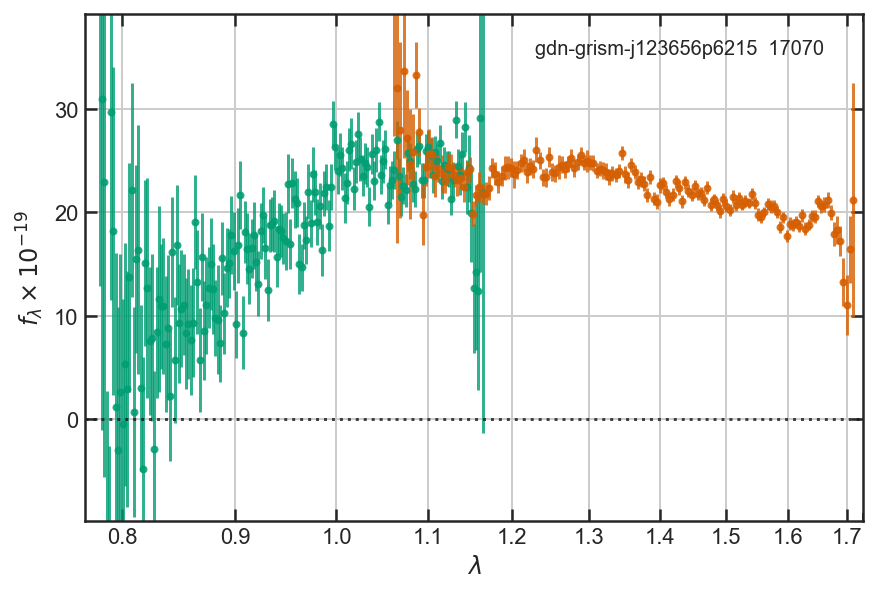

In [917]:
fit = mb.template_at_z(rshift, templates = temps, fitter='lstsq')
print(fit['chi2']/mb.DoF)

select = False
clip = False
omit = False


if clip or omit:
    select = True

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[12,12])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

BEAM_exempt =[]
ids = 0
omitspec = []
clipspec = []

for bm in mb.beams:
    xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

    flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
    xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

    if bm.grism.filter == 'G102':
        IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
        ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
    else:
        IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
        ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 

        
        ### selection for bad beams
    if select:
        #condition of bad beams
        bex = False
        
        for i in range(len(xspec)):
            if bm.grism.filter == 'G102' and 8300< xspec[i] < 8500 and (yspec[i]/yspecm[i]) >0.5E-17:
                bex = True
                clipspec.append(0)
                omitspec.append(1)        
                break

    
#             if bm.grism.filter == 'G141' and 12000< xspec[i] < 13000 and (yspec[i]/yspecm[i]) > 0.2E-17:
#                 bex = True
# #                 clipspec.append(0)
# #                 omitspec.append(1)        
#                 break
                
#             if bm.grism.filter == 'G141':
#                 bex = True
# #                 clipspec.append(1)
# #                 omitspec.append(0)
#                 break
        if bex:
            BEAM_exempt.append(bm.grism.parent_file)

fig = mb.oned_figure(show_beams=False)

### set up selection settings
if clip and not omit:
    clipspec = np.ones(len(BEAM_exempt))
    omitspec = np.zeros(len(BEAM_exempt))
if omit and not clip:
    omitspec = np.ones(len(BEAM_exempt))
    clipspec = np.zeros(len(BEAM_exempt))
if omit and clip:
    pass
    ###selection tool TBD

### if beams are to be clipped
multclip = False

if clip:
    Clims =[[0,12000]]
else:
    clip_lims = []
    clipspec = np.zeros(len(BEAM_exempt))

if multclip:
    pass
    ###selection tool TBD
else:
    clip_lims = [Clims for U in BEAM_exempt]

if clip:
    idc = 0
    for bm in mb.beams:
        if bm.grism.parent_file in BEAM_exempt:
            xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar) 
            for lms in clip_lims[idc]:
                if clipspec[idc] == 1:
                    for i in range(len(xspec)):
                        if lms[0] < xspec[i]< lms[1]:
                            bm.grism.data['SCI'].T[i] = np.zeros_like(bm.grism.data['SCI'].T[i])
                            bm.grism.data['ERR'].T[i] = np.ones_like(bm.grism.data['ERR'].T[i])*1000
            idc+=1 
                
### if beams are to be omitted
if omit:
    ido = 0
    IDB = []
    for i in range(len(mb.beams)):
        if mb.beams[i].grism.parent_file in BEAM_exempt:
            if omitspec[ido] == 1:
                IDB.append(i) 
            ido += 1
                   
    BEAMS = []
    
    for i in range(len(mb.beams)):
        if i not in IDB:
            BEAMS.append(mb.beams[i])

else:
    BEAMS = mb.beams
    omitspec = np.zeros(len(BEAM_exempt))

### remake mb
mb = multifit.MultiBeam(BEAMS, **args)

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[12,12])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for bm in mb.beams:
    xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

    flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
    xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

    if bm.grism.filter == 'G102':
        IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
        ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
    else:
        IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
        ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 

fig = mb.oned_figure(show_beams=False)

print(BEAM_exempt)
print(clipspec,clip_lims)
print(omitspec)

fit = mb.template_at_z(rshift, templates = temps, fitter='lstsq')
print(fit['chi2']/mb.DoF)

np.save('../beams/beam_config/{}_{}_ex'.format(alldb.field[idx], alldb.id[idx]),[BEAM_exempt])
np.save('../beams/beam_config/{}_{}'.format(alldb.field[idx], alldb.id[idx]),[clip_lims,clipspec,omitspec])

In [840]:
# mb.beams[~np.array(IDB)]
mb.beams[~np.array([4, 5, 6, 7]).astype(int)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [887]:
for fl in glob('../beams/beam_config/*'):
    print(np.load(fl))
    print(fl)

[]
../beams/beam_config/GND_10639.npy
[]
../beams/beam_config/GND_10639_ex.npy
[]
../beams/beam_config/GND_11279.npy
[]
../beams/beam_config/GND_11279_ex.npy
[]
../beams/beam_config/GND_11460.npy
[]
../beams/beam_config/GND_11460_ex.npy
[]
../beams/beam_config/GND_11814.npy
[]
../beams/beam_config/GND_11814_ex.npy
[[list([[13500, 90000]])]
 [0.0]
 [1.0]]
../beams/beam_config/GND_11839.npy
[['ib3747zyq_flt.fits']]
../beams/beam_config/GND_11839_ex.npy
[]
../beams/beam_config/GND_12078.npy
[]
../beams/beam_config/GND_12078_ex.npy
[]
../beams/beam_config/GND_12451.npy
[]
../beams/beam_config/GND_12451_ex.npy
[]
../beams/beam_config/GND_12478.npy
[]
../beams/beam_config/GND_12478_ex.npy
[]
../beams/beam_config/GND_12481.npy
[]
../beams/beam_config/GND_12481_ex.npy
[]
../beams/beam_config/GND_12617.npy
[]
../beams/beam_config/GND_12617_ex.npy
[]
../beams/beam_config/GND_12674.npy
[]
../beams/beam_config/GND_12674_ex.npy
[]
../beams/beam_config/GND_12739.npy
[]
../beams/beam_config/GND_12739

In [525]:
mb_g102 = multifit.MultiBeam(BEAMS, fcontam=mb.fcontam, 
                                 min_sens=mb.min_sens, min_mask=mb.min_mask, 
                                 group_name=mb.group_name+'-g102')

for b in mb_g102.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb_g102.initialize_masked_arrays()

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = n

line Hg (3.798708250044547e-18, 4.2762125035895584e-17)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2914: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/vestrada/miniconda3

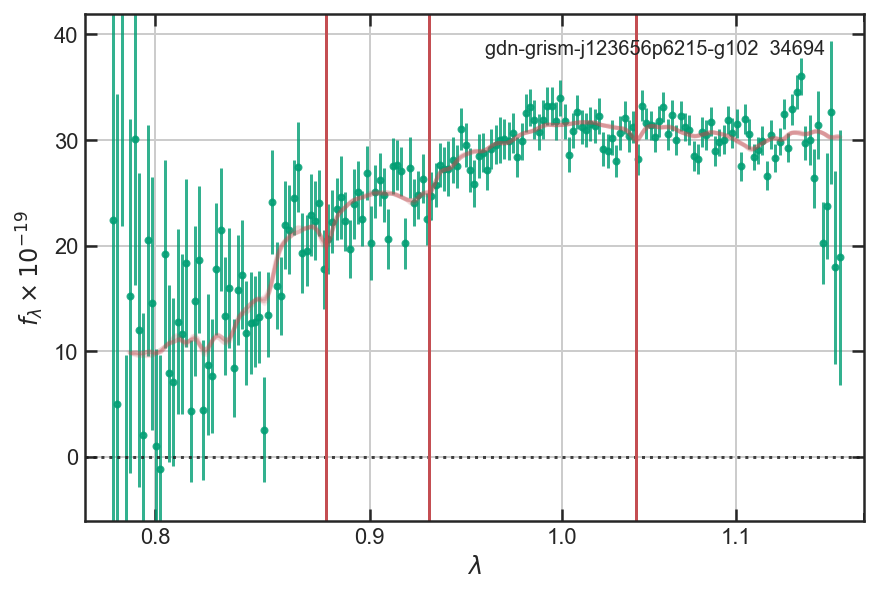

In [526]:
fit = mb_g102.template_at_z(Qdb.zgrism[idx], templates = temps, fitter='lstsq')

for k in fit['cfit']:
    if fit['cfit'][k][0] > 0 and k[0] == 'l':
        print(k,fit['cfit'][k])
fit['chi2']/mb_g102.DoF
fig = mb_g102.oned_figure(show_beams=False, tfit=fit)
plt.axvline(0.4102 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.4341 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.4862 *(1 + Qdb.zgrism[idx]), color = 'r')
plt.axvline(0.6564 *(1 + Qdb.zgrism[idx]), color = 'r')

In [520]:
fit['chi2']/mb_g102.DoF

0.9607321597596474

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2922: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((fl-er*0.)[clip], 5))
/Users/vestrada/minicon

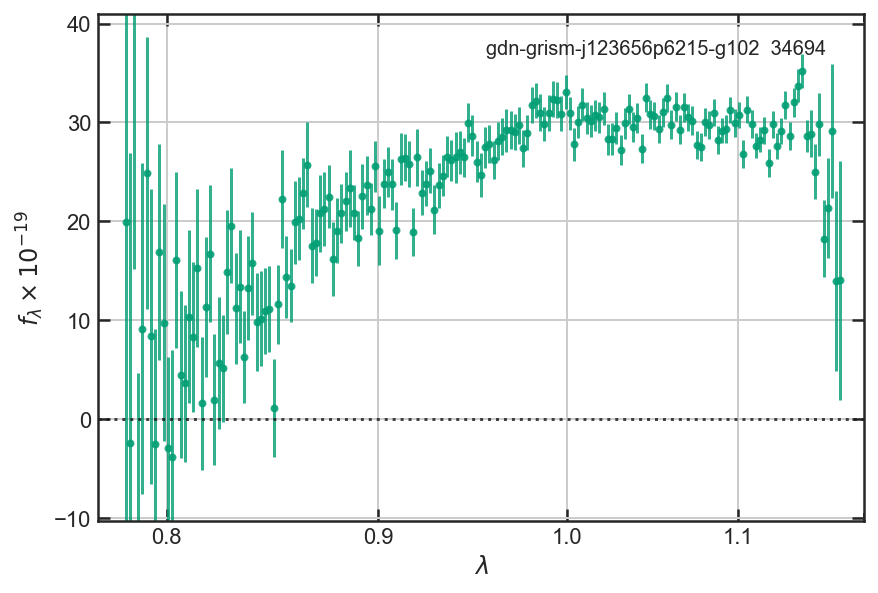

In [514]:
fig = mb_g102.oned_figure(show_beams=False)


In [522]:
mb.beams[0].grism.parent_file

'icxt41f1q_flt.fits'